In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#----------------------------------------------------------------------#
#   验证集的划分在train.py代码里面进行
#   test.txt和val.txt里面没有内容是正常的。训练不会使用到。
#----------------------------------------------------------------------#
#'''#
#--------------------------------注意----------------------------------#
#如果在pycharm中运行时提示：
#FileNotFoundError: [WinError 3] 系统找不到指定的路径。: './VOCdevkit/VOC2007/Annotations'
#这是pycharm运行目录的问题，最简单的方法是将该文件复制到根目录后运行。
#可以查询一下相对目录和根目录的概念。在VSCODE中没有这个问题。
#--------------------------------注意----------------------------------#

import os
import random 
random.seed(0)

xmlfilepath='/content/drive/MyDrive/FASTER-RCNN/VOC/Annotations'
saveBasePath='/content/drive/MyDrive/FASTER-RCNN/VOC/ImageSets/Main/'
 
#----------------------------------------------------------------------#
#   想要增加测试集修改trainval_percent
#   train_percent不需要修改
#----------------------------------------------------------------------#
trainval_percent=0.9
train_percent=1  #10% dataset is testset

temp_xml = os.listdir(xmlfilepath)
total_xml = []
for xml in temp_xml:
    if xml.endswith(".xml"):
        total_xml.append(xml)

num=len(total_xml)  
listt=range(num)  
tv=int(num*trainval_percent)  
tr=int(tv*train_percent)  
trainval= random.sample(listt,tv)  
train=random.sample(trainval,tr)  
 
print("train and val size",tv)
print("traub suze",tr)
ftrainval = open(os.path.join(saveBasePath,'trainval.txt'), 'w')  
ftest = open(os.path.join(saveBasePath,'test.txt'), 'w')  
ftrain = open(os.path.join(saveBasePath,'train.txt'), 'w')  
fval = open(os.path.join(saveBasePath,'val.txt'), 'w')  
 
for i  in listt:  
    name=total_xml[i][:-4]+'\n'  
    if i in trainval:  
        ftrainval.write(name)  
        if i in train:  
            ftrain.write(name)  
        else:  
            fval.write(name)  
    else:  
        ftest.write(name)  
  
ftrainval.close()  
ftrain.close()  
fval.close()  
ftest .close()


train and val size 389
traub suze 389


In [3]:

import xml.etree.ElementTree as ET
from os import getcwd

sets=[('car', 'train'), ('car', 'val'), ('car', 'test')]
#-----------------------------------------------------#
#   这里设定的classes顺序要和model_data里的txt一样
#-----------------------------------------------------#
classes = ['licence']

def convert_annotation( image_id, list_file):
    in_file = open('/content/drive/MyDrive/FASTER-RCNN/VOC/Annotations/%s.xml'%(image_id), encoding='utf-8')
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = 0 
        if obj.find('difficult')!=None:
            difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(float(xmlbox.find('xmin').text)), int(float(xmlbox.find('ymin').text)), int(float(xmlbox.find('xmax').text)), int(float(xmlbox.find('ymax').text)))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

wd = getcwd()

for car, image_set in sets:
    image_ids = open('/content/drive/MyDrive/FASTER-RCNN/VOC/ImageSets/Main/%s.txt'%( image_set), encoding='utf-8').read().strip().split()
    list_file = open('/content/drive/MyDrive/FASTER-RCNN/%s_%s.txt'%(car, image_set), 'w', encoding='utf-8')
    for image_id in image_ids:
        list_file.write('/content/drive/MyDrive/FASTER-RCNN/VOC/JPEGImages/%s.png'%(image_id))
        convert_annotation( image_id, list_file)
        list_file.write('\n')
    list_file.close()

In [4]:
import warnings

import torch
from torch import nn
from torchvision.ops import RoIPool

warnings.filterwarnings("ignore")

class VGG16RoIHead(nn.Module):
    def __init__(self, n_class, roi_size, spatial_scale, classifier):
        super(VGG16RoIHead, self).__init__()
        self.classifier = classifier
        #--------------------------------------#
        #   对ROIPooling后的的结果进行回归预测
        #--------------------------------------#
        self.cls_loc = nn.Linear(4096, n_class * 4)
        #-----------------------------------#
        #   对ROIPooling后的的结果进行分类
        #-----------------------------------#
        self.score = nn.Linear(4096, n_class)
        #-----------------------------------#
        #   权值初始化
        #-----------------------------------#
        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)

        self.roi = RoIPool((roi_size, roi_size), spatial_scale)
        
    def forward(self, x, rois, roi_indices, img_size):
        n, _, _, _ = x.shape
        if x.is_cuda:
            roi_indices = roi_indices.cuda()
            rois = rois.cuda()

        rois_feature_map = torch.zeros_like(rois)
        rois_feature_map[:, [0,2]] = rois[:, [0,2]] / img_size[1] * x.size()[3]
        rois_feature_map[:, [1,3]] = rois[:, [1,3]] / img_size[0] * x.size()[2]

        indices_and_rois = torch.cat([roi_indices[:, None], rois_feature_map], dim=1)
        #-----------------------------------#
        #   利用建议框对公用特征层进行截取
        #-----------------------------------#
        pool = self.roi(x, indices_and_rois)
        #-----------------------------------#
        #   利用classifier网络进行特征提取
        #-----------------------------------#
        pool = pool.view(pool.size(0), -1)
        # 当输入为一张图片的时候，这里获得的f7的shape为[300, 4096]
        fc7 = self.classifier(pool)

        roi_cls_locs = self.cls_loc(fc7)
        roi_scores = self.score(fc7)

        roi_cls_locs = roi_cls_locs.view(n, -1, roi_cls_locs.size(1))
        roi_scores = roi_scores.view(n, -1, roi_scores.size(1))
        return roi_cls_locs, roi_scores

class Resnet50RoIHead(nn.Module):
    def __init__(self, n_class, roi_size, spatial_scale, classifier):
        super(Resnet50RoIHead, self).__init__()
        self.classifier = classifier
        #--------------------------------------#
        #   对ROIPooling后的的结果进行回归预测
        #--------------------------------------#
        self.cls_loc = nn.Linear(2048, n_class * 4)
        #-----------------------------------#
        #   对ROIPooling后的的结果进行分类
        #-----------------------------------#
        self.score = nn.Linear(2048, n_class)
        #-----------------------------------#
        #   权值初始化
        #-----------------------------------#
        normal_init(self.cls_loc, 0, 0.001)
        normal_init(self.score, 0, 0.01)

        self.roi = RoIPool((roi_size, roi_size), spatial_scale)

    def forward(self, x, rois, roi_indices, img_size):
        n, _, _, _ = x.shape
        if x.is_cuda:
            roi_indices = roi_indices.cuda()
            rois = rois.cuda()

        rois_feature_map = torch.zeros_like(rois)
        rois_feature_map[:, [0,2]] = rois[:, [0,2]] / img_size[1] * x.size()[3]
        rois_feature_map[:, [1,3]] = rois[:, [1,3]] / img_size[0] * x.size()[2]

        indices_and_rois = torch.cat([roi_indices[:, None], rois_feature_map], dim=1)
        #-----------------------------------#
        #   利用建议框对公用特征层进行截取
        #-----------------------------------#
        pool = self.roi(x, indices_and_rois)
        #-----------------------------------#
        #   利用classifier网络进行特征提取
        #-----------------------------------#
        fc7 = self.classifier(pool)
        # 当输入为一张图片的时候，这里获得的f7的shape为[300, 2048]
        fc7 = fc7.view(fc7.size(0), -1)

        roi_cls_locs = self.cls_loc(fc7)
        roi_scores = self.score(fc7)
        roi_cls_locs = roi_cls_locs.view(n, -1, roi_cls_locs.size(1))
        roi_scores = roi_scores.view(n, -1, roi_scores.size(1))
        return roi_cls_locs, roi_scores

def normal_init(m, mean, stddev, truncated=False):
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()


# RESNET50

In [5]:
import math

import torch.nn as nn


class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False) #1*1 onv2d compressive the channel number
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False) # 3*3 feature extract
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False) #expand the channel number
        self.bn3 = nn.BatchNorm2d(planes * 4) #

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x) #1*1 conv2d
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) #3*3 conv2d
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out) #1*1 expand the chnnel number
        out = self.bn3(out)
        if self.downsample is not None: # if residual not none, conv2d
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        #-----------------------------------#
        #   假设输入进来的图片是600,600,3
        #-----------------------------------#
        self.inplanes = 64
        super(ResNet, self).__init__()

        # 600,600,3 -> 300,300,64 input image:600,600,3
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # 300,300,64 -> 150,150,64
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, ceil_mode=True)

        # 150,150,64 -> 150,150,256
        self.layer1 = self._make_layer(block, 64, layers[0])
        # 150,150,256 -> 75,75,512
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # 75,75,512 -> 38,38,1024 到这里可以获得一个38,38,1024的共享特征层
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # self.layer4被用在classifier模型中
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        #-------------------------------------------------------------------#
        #   当模型需要进行高和宽的压缩的时候，就需要用到残差边的downsample
        #-------------------------------------------------------------------#
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def resnet50():
    model = ResNet(Bottleneck, [3, 4, 6, 3]) # each compression has 3,4,6,3 blocks
    #----------------------------------------------------------------------------#
    #   获取特征提取部分，从conv1到model.layer3，最终获得一个38,38,1024的特征层
    #----------------------------------------------------------------------------#
    features = list([model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2, model.layer3])
    #features = [model.conv1, model.bn1, model.relu, model.maxpool, model.layer1, model.layer2, model.layer3]
    #----------------------------------------------------------------------------#
    #   获取分类部分，从model.layer4到model.avgpool
    #----------------------------------------------------------------------------#
    classifier = list([model.layer4, model.avgpool])
    #classifier = [model.layer4, model.avgpool]
    features = nn.Sequential(*features)
    classifier = nn.Sequential(*classifier)
    return features, classifier

# anchor box

[[ -45.254833  -90.50967    45.254833   90.50967 ]
 [ -90.50967  -181.01933    90.50967   181.01933 ]
 [-181.01933  -362.03867   181.01933   362.03867 ]
 [ -64.        -64.         64.         64.      ]
 [-128.       -128.        128.        128.      ]
 [-256.       -256.        256.        256.      ]
 [ -90.50967   -45.254833   90.50967    45.254833]
 [-181.01933   -90.50967   181.01933    90.50967 ]
 [-362.03867  -181.01933   362.03867   181.01933 ]]
(12996, 4)


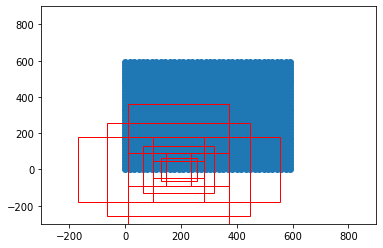

In [6]:
import numpy as np


def generate_anchor_base(base_size=16, ratios=[0.5, 1, 2],
                         anchor_scales=[8, 16, 32]):

    anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = base_size * anchor_scales[j] * np.sqrt(ratios[i])
            w = base_size * anchor_scales[j] * np.sqrt(1. / ratios[i])

            index = i * len(anchor_scales) + j
            anchor_base[index, 0] = - h / 2.
            anchor_base[index, 1] = - w / 2.
            anchor_base[index, 2] = h / 2.
            anchor_base[index, 3] = w / 2.
    return anchor_base

def _enumerate_shifted_anchor(anchor_base, feat_stride, height, width):
    # 计算网格中心点
    shift_x = np.arange(0, width * feat_stride, feat_stride)
    shift_y = np.arange(0, height * feat_stride, feat_stride)
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shift = np.stack((shift_x.ravel(),shift_y.ravel(),
                      shift_x.ravel(),shift_y.ravel(),), axis=1)

    # 每个网格点上的9个先验框
    A = anchor_base.shape[0]
    K = shift.shape[0]
    anchor = anchor_base.reshape((1, A, 4)) + \
             shift.reshape((K, 1, 4))
    # 所有的先验框
    anchor = anchor.reshape((K * A, 4)).astype(np.float32)
    return anchor
    
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    nine_anchors = generate_anchor_base()
    print(nine_anchors)

    height, width, feat_stride = 38,38,16
    anchors_all = _enumerate_shifted_anchor(nine_anchors,feat_stride,height,width)
    print(np.shape(anchors_all))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ylim(-300,900)
    plt.xlim(-300,900)
    shift_x = np.arange(0, width * feat_stride, feat_stride)
    shift_y = np.arange(0, height * feat_stride, feat_stride)
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    plt.scatter(shift_x,shift_y)
    box_widths = anchors_all[:,2]-anchors_all[:,0]
    box_heights = anchors_all[:,3]-anchors_all[:,1]
    
    for i in [108,109,110,111,112,113,114,115,116]:
        rect = plt.Rectangle([anchors_all[i, 0],anchors_all[i, 1]],box_widths[i],box_heights[i],color="r",fill=False)
        ax.add_patch(rect)
    
    plt.show()

# utils

In [7]:
import os

import numpy as np
import scipy.signal
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from torchvision.ops import nms

def get_new_img_size(width, height, img_min_side=600):
    if width <= height:
        f = float(img_min_side) / width
        resized_height = int(f * height)
        resized_width = int(img_min_side)
    else:
        f = float(img_min_side) / height
        resized_width = int(f * width)
        resized_height = int(img_min_side)

    return resized_width, resized_height

def bbox2loc(src_bbox, dst_bbox):
    width = src_bbox[:, 2] - src_bbox[:, 0]
    height = src_bbox[:, 3] - src_bbox[:, 1]
    ctr_x = src_bbox[:, 0] + 0.5 * width
    ctr_y = src_bbox[:, 1] + 0.5 * height

    base_width = dst_bbox[:, 2] - dst_bbox[:, 0]
    base_height = dst_bbox[:, 3] - dst_bbox[:, 1]
    base_ctr_x = dst_bbox[:, 0] + 0.5 * base_width
    base_ctr_y = dst_bbox[:, 1] + 0.5 * base_height

    eps = np.finfo(height.dtype).eps
    width = np.maximum(width, eps)
    height = np.maximum(height, eps)

    dx = (base_ctr_x - ctr_x) / width
    dy = (base_ctr_y - ctr_y) / height
    dw = np.log(base_width / width)
    dh = np.log(base_height / height)

    loc = np.vstack((dx, dy, dw, dh)).transpose()
    return loc

def loc2bbox(src_bbox, loc):
    if src_bbox.size()[0] == 0:
        return torch.zeros((0, 4), dtype=loc.dtype)

    src_width = torch.unsqueeze(src_bbox[:, 2] - src_bbox[:, 0], -1)
    src_height = torch.unsqueeze(src_bbox[:, 3] - src_bbox[:, 1], -1)
    src_ctr_x = torch.unsqueeze(src_bbox[:, 0], -1) + 0.5 * src_width
    src_ctr_y = torch.unsqueeze(src_bbox[:, 1], -1) + 0.5 * src_height

    dx = loc[:, 0::4]
    dy = loc[:, 1::4]
    dw = loc[:, 2::4]
    dh = loc[:, 3::4]

    ctr_x = dx * src_width + src_ctr_x
    ctr_y = dy * src_height + src_ctr_y
    w = torch.exp(dw) * src_width
    h = torch.exp(dh) * src_height
    dst_bbox = torch.zeros_like(loc)
    dst_bbox[:, 0::4] = ctr_x - 0.5 * w
    dst_bbox[:, 1::4] = ctr_y - 0.5 * h
    dst_bbox[:, 2::4] = ctr_x + 0.5 * w
    dst_bbox[:, 3::4] = ctr_y + 0.5 * h

    return dst_bbox

class DecodeBox():
    def __init__(self, std, mean, num_classes):
        self.std = std
        self.mean = mean
        self.num_classes = num_classes + 1    

    def forward(self, roi_cls_locs, roi_scores, rois, height, width, nms_iou, score_thresh):
        roi_cls_loc = (roi_cls_locs * self.std + self.mean)
        roi_cls_loc = roi_cls_loc.view([-1, self.num_classes, 4])

        # 利用classifier网络的预测结果对建议框进行调整获得预测框
        roi = rois.view((-1, 1, 4)).expand_as(roi_cls_loc)
        cls_bbox = loc2bbox(roi.reshape((-1, 4)), roi_cls_loc.reshape((-1, 4)))
        cls_bbox = cls_bbox.view([-1, (self.num_classes), 4])

        # 防止预测框超出图片范围
        cls_bbox[..., [0, 2]] = (cls_bbox[..., [0, 2]]).clamp(min=0, max=width)
        cls_bbox[..., [1, 3]] = (cls_bbox[..., [1, 3]]).clamp(min=0, max=height)
        
        prob = F.softmax(roi_scores, dim=-1)

        class_conf, class_pred = torch.max(prob, dim=-1)
        #----------------------------------------------------------#
        #   利用置信度进行第一轮筛选
        #----------------------------------------------------------#
        conf_mask = (class_conf >= score_thresh)
        #----------------------------------------------------------#
        #   根据置信度进行预测结果的筛选
        #----------------------------------------------------------#
        cls_bbox = cls_bbox[conf_mask]
        class_conf = class_conf[conf_mask]
        class_pred = class_pred[conf_mask]

        output = []
        for l in range(1, self.num_classes):
            arg_mask = class_pred == l
            #------------------------------------------#
            #   取出对应的框和置信度
            #------------------------------------------#
            cls_bbox_l = cls_bbox[arg_mask, l, :]
            class_conf_l = class_conf[arg_mask]
            
            if len(class_conf_l) == 0:
                continue
            
            detections_class = torch.cat([cls_bbox_l, torch.unsqueeze(class_pred[arg_mask] - 1, -1).float(), torch.unsqueeze(class_conf_l, -1)], -1)
            #------------------------------------------#
            #   使用官方自带的非极大抑制会速度更快一些！
            #------------------------------------------#
            keep = nms(
                detections_class[:, :4],
                detections_class[:, -1],
                nms_iou
            )
            output.extend(detections_class[keep].cpu().numpy())

        return output
        
def bbox_iou(bbox_a, bbox_b):
    if bbox_a.shape[1] != 4 or bbox_b.shape[1] != 4:
        print(bbox_a, bbox_b)
        raise IndexError
    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])
    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)

class AnchorTargetCreator(object):
    def __init__(self, n_sample=256, pos_iou_thresh=0.7, neg_iou_thresh=0.3, pos_ratio=0.5):
        self.n_sample = n_sample
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh = neg_iou_thresh
        self.pos_ratio = pos_ratio

    def __call__(self, bbox, anchor, img_size):
        argmax_ious, label = self._create_label(anchor, bbox)
        if (label>0).any():
            loc = bbox2loc(anchor, bbox[argmax_ious])
            return loc, label
        else:
            return np.zeros_like(anchor), label

    def _calc_ious(self, anchor, bbox):
        #----------------------------------------------#
        #   anchor和bbox的iou
        #   获得的ious的shape为[num_anchors, num_gt]
        #----------------------------------------------#
        ious = bbox_iou(anchor, bbox)

        if len(bbox)==0:
            return np.zeros(len(anchor), np.int32), np.zeros(len(anchor)), np.zeros(len(bbox))
        #---------------------------------------------------------#
        #   获得每一个先验框最对应的真实框  [num_anchors, ]
        #---------------------------------------------------------#
        argmax_ious = ious.argmax(axis=1)
        #---------------------------------------------------------#
        #   找出每一个先验框最对应的真实框的iou  [num_anchors, ]
        #---------------------------------------------------------#
        max_ious = np.max(ious, axis=1)
        
        #---------------------------------------------------------#
        #   获得每一个真实框最对应的先验框  [num_gt, ]
        #---------------------------------------------------------#
        gt_argmax_ious = ious.argmax(axis=0)

        #---------------------------------------------------------#
        #   保证每一个真实框都存在对应的先验框
        #---------------------------------------------------------#
        for i in range(len(gt_argmax_ious)):
            argmax_ious[gt_argmax_ious[i]] = i

        return argmax_ious, max_ious, gt_argmax_ious
        
    def _create_label(self, anchor, bbox):
        # ------------------------------------------ #
        #   1是正样本，0是负样本，-1忽略
        #   初始化的时候全部设置为-1
        # ------------------------------------------ #
        label = np.empty((len(anchor),), dtype=np.int32)
        label.fill(-1)

        # ------------------------------------------------------------------------ #
        #   argmax_ious为每个先验框对应的最大的真实框的序号         [num_anchors, ]
        #   max_ious为每个真实框对应的最大的真实框的iou             [num_anchors, ]
        #   gt_argmax_ious为每一个真实框对应的最大的先验框的序号    [num_gt, ]
        # ------------------------------------------------------------------------ #
        argmax_ious, max_ious, gt_argmax_ious = self._calc_ious(anchor, bbox)
        
        # ----------------------------------------------------- #
        #   如果小于门限值则设置为负样本
        #   如果大于门限值则设置为正样本
        #   每个真实框至少对应一个先验框
        # ----------------------------------------------------- #
        label[max_ious < self.neg_iou_thresh] = 0
        label[max_ious >= self.pos_iou_thresh] = 1
        if len(gt_argmax_ious)>0:
            label[gt_argmax_ious] = 1

        # ----------------------------------------------------- #
        #   判断正样本数量是否大于128，如果大于则限制在128
        # ----------------------------------------------------- #
        n_pos = int(self.pos_ratio * self.n_sample)
        pos_index = np.where(label == 1)[0]
        if len(pos_index) > n_pos:
            disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
            label[disable_index] = -1

        # ----------------------------------------------------- #
        #   平衡正负样本，保持总数量为256
        # ----------------------------------------------------- #
        n_neg = self.n_sample - np.sum(label == 1)
        neg_index = np.where(label == 0)[0]
        if len(neg_index) > n_neg:
            disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace=False)
            label[disable_index] = -1

        return argmax_ious, label


class ProposalTargetCreator(object):
    def __init__(self, n_sample=128, pos_ratio=0.5, pos_iou_thresh=0.5, neg_iou_thresh_high=0.5, neg_iou_thresh_low=0):
        self.n_sample = n_sample
        self.pos_ratio = pos_ratio
        self.pos_roi_per_image = np.round(self.n_sample * self.pos_ratio)
        self.pos_iou_thresh = pos_iou_thresh
        self.neg_iou_thresh_high = neg_iou_thresh_high
        self.neg_iou_thresh_low = neg_iou_thresh_low

    def __call__(self, roi, bbox, label, loc_normalize_mean=(0., 0., 0., 0.), loc_normalize_std=(0.1, 0.1, 0.2, 0.2)):
        roi = np.concatenate((roi.detach().cpu().numpy(), bbox), axis=0)
        # ----------------------------------------------------- #
        #   计算建议框和真实框的重合程度
        # ----------------------------------------------------- #
        iou = bbox_iou(roi, bbox)
        
        if len(bbox)==0:
            gt_assignment = np.zeros(len(roi), np.int32)
            max_iou = np.zeros(len(roi))
            gt_roi_label = np.zeros(len(roi))
        else:
            #---------------------------------------------------------#
            #   获得每一个建议框最对应的真实框  [num_roi, ]
            #---------------------------------------------------------#
            gt_assignment = iou.argmax(axis=1)
            #---------------------------------------------------------#
            #   获得每一个建议框最对应的真实框的iou  [num_roi, ]
            #---------------------------------------------------------#
            max_iou = iou.max(axis=1)

            #---------------------------------------------------------#
            #   真实框的标签要+1因为有背景的存在
            #---------------------------------------------------------#
            gt_roi_label = label[gt_assignment] + 1

        #----------------------------------------------------------------#
        #   满足建议框和真实框重合程度大于neg_iou_thresh_high的作为负样本
        #   将正样本的数量限制在self.pos_roi_per_image以内
        #----------------------------------------------------------------#
        pos_index = np.where(max_iou >= self.pos_iou_thresh)[0]
        pos_roi_per_this_image = int(min(self.pos_roi_per_image, pos_index.size))
        if pos_index.size > 0:
            pos_index = np.random.choice(pos_index, size=pos_roi_per_this_image, replace=False)

        #-----------------------------------------------------------------------------------------------------#
        #   满足建议框和真实框重合程度小于neg_iou_thresh_high大于neg_iou_thresh_low作为负样本
        #   将正样本的数量和负样本的数量的总和固定成self.n_sample
        #-----------------------------------------------------------------------------------------------------#
        neg_index = np.where((max_iou < self.neg_iou_thresh_high) & (max_iou >= self.neg_iou_thresh_low))[0]
        neg_roi_per_this_image = self.n_sample - pos_roi_per_this_image
        neg_roi_per_this_image = int(min(neg_roi_per_this_image, neg_index.size))
        if neg_index.size > 0:
            neg_index = np.random.choice(neg_index, size=neg_roi_per_this_image, replace=False)

        #---------------------------------------------------------#
        #   sample_roi      [n_sample, ]
        #   gt_roi_loc      [n_sample, 4]
        #   gt_roi_label    [n_sample, ]
        #---------------------------------------------------------#
        keep_index = np.append(pos_index, neg_index)

        sample_roi = roi[keep_index]
        if len(bbox)==0:
            return sample_roi, np.zeros_like(sample_roi), gt_roi_label[keep_index]

        gt_roi_loc = bbox2loc(sample_roi, bbox[gt_assignment[keep_index]])
        gt_roi_loc = ((gt_roi_loc - np.array(loc_normalize_mean, np.float32)) / np.array(loc_normalize_std, np.float32))

        gt_roi_label = gt_roi_label[keep_index]
        gt_roi_label[pos_roi_per_this_image:] = 0
        return sample_roi, gt_roi_loc, gt_roi_label

def weights_init(net, init_type='normal', init_gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and classname.find('Conv') != -1:
            if init_type == 'normal':
                torch.nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                torch.nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                torch.nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                torch.nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
            torch.nn.init.constant_(m.bias.data, 0.0)
    print('initialize network with %s type' % init_type)
    net.apply(init_func)
    
class LossHistory():
    def __init__(self, log_dir):
        import datetime
        curr_time = datetime.datetime.now()
        time_str = datetime.datetime.strftime(curr_time,'%Y_%m_%d_%H_%M_%S')
        self.log_dir    = log_dir
        self.time_str   = time_str
        self.save_path  = os.path.join(self.log_dir, "loss_" + str(self.time_str))
        self.losses     = []
        self.val_loss   = []
        
        os.makedirs(self.save_path)

    def append_loss(self, loss, val_loss):
        self.losses.append(loss)
        self.val_loss.append(val_loss)
        with open(os.path.join(self.save_path, "epoch_loss_" + str(self.time_str) + ".txt"), 'a') as f:
            f.write(str(loss))
            f.write("\n")
        with open(os.path.join(self.save_path, "epoch_val_loss_" + str(self.time_str) + ".txt"), 'a') as f:
            f.write(str(val_loss))
            f.write("\n")
        self.loss_plot()

    def loss_plot(self):
        iters = range(len(self.losses))

        plt.figure()
        plt.plot(iters, self.losses, 'red', linewidth = 2, label='train loss')
        plt.plot(iters, self.val_loss, 'coral', linewidth = 2, label='val loss')
        try:
            if len(self.losses) < 25:
                num = 5
            else:
                num = 15
            
            plt.plot(iters, scipy.signal.savgol_filter(self.losses, num, 3), 'green', linestyle = '--', linewidth = 2, label='smooth train loss')
            plt.plot(iters, scipy.signal.savgol_filter(self.val_loss, num, 3), '#8B4513', linestyle = '--', linewidth = 2, label='smooth val loss')
        except:
            pass

        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc="upper right")

        plt.savefig(os.path.join(self.save_path, "epoch_loss_" + str(self.time_str) + ".png"))

# dataloader

In [8]:
import cv2
import numpy as np
from PIL import Image
from torch.utils.data.dataset import Dataset


class FRCNNDataset(Dataset):
    def __init__(self, train_lines, shape=[600,600], is_train=True):
        self.train_lines = train_lines
        self.train_batches = len(train_lines)
        self.shape = shape
        self.is_train = is_train

    def __len__(self):
        return self.train_batches

    def rand(self, a=0, b=1):
        return np.random.rand() * (b - a) + a
        
    def get_random_data(self, annotation_line, jitter=.3, hue=.1, sat=1.5, val=1.5, random=True):
        '''r实时数据增强的随机预处理'''
        line = annotation_line.split()
        image = Image.open(line[0])
        iw, ih = image.size
        h,w = self.shape
        box = np.array([np.array(list(map(int,box.split(',')))) for box in line[1:]])
        #box = np.array([np.array(map(int,box.split(','))) for box in line[1:]])
        if not random:
            # resize image
            scale = min(w/iw, h/ih)
            nw = int(iw*scale)
            nh = int(ih*scale)
            dx = (w-nw)//2
            dy = (h-nh)//2

            image = image.resize((nw,nh), Image.BICUBIC)
            new_image = Image.new('RGB', (w,h), (128,128,128))
            new_image.paste(image, (dx, dy))
            image_data = np.array(new_image, np.float32)

            # correct boxes
            box_data = np.zeros((len(box),5))
            if len(box)>0:
                np.random.shuffle(box)
                box[:, [0,2]] = box[:, [0,2]]*nw/iw + dx
                box[:, [1,3]] = box[:, [1,3]]*nh/ih + dy
                box[:, 0:2][box[:, 0:2]<0] = 0
                box[:, 2][box[:, 2]>w] = w
                box[:, 3][box[:, 3]>h] = h
                box_w = box[:, 2] - box[:, 0]
                box_h = box[:, 3] - box[:, 1]
                box = box[np.logical_and(box_w>1, box_h>1)]
                box_data = np.zeros((len(box),5))
                box_data[:len(box)] = box

            return image_data, box_data
            
        # resize image
        new_ar = w/h * self.rand(1-jitter,1+jitter)/self.rand(1-jitter,1+jitter)
        scale = self.rand(.5, 1.5)
        if new_ar < 1:
            nh = int(scale*h)
            nw = int(nh*new_ar)
        else:
            nw = int(scale*w)
            nh = int(nw/new_ar)
        image = image.resize((nw,nh), Image.BICUBIC)

        # place image
        dx = int(self.rand(0, w-nw))
        dy = int(self.rand(0, h-nh))
        new_image = Image.new('RGB', (w,h), (128,128,128))
        new_image.paste(image, (dx, dy))
        image = new_image

        # flip image or not
        flip = self.rand()<.5
        if flip: image = image.transpose(Image.FLIP_LEFT_RIGHT)

        # distort image
        hue = self.rand(-hue, hue)
        sat = self.rand(1, sat) if self.rand()<.5 else 1/self.rand(1, sat)
        val = self.rand(1, val) if self.rand()<.5 else 1/self.rand(1, val)
        x = cv2.cvtColor(np.array(image,np.float32)/255, cv2.COLOR_RGB2HSV)
        x[..., 0] += hue*360
        x[..., 0][x[..., 0]>1] -= 1
        x[..., 0][x[..., 0]<0] += 1
        x[..., 1] *= sat
        x[..., 2] *= val
        x[x[:,:, 0]>360, 0] = 360
        x[:, :, 1:][x[:, :, 1:]>1] = 1
        x[x<0] = 0
        image_data = cv2.cvtColor(x, cv2.COLOR_HSV2RGB)*255 # numpy array, 0 to 1

        # correct boxes
        box_data = np.zeros((len(box),5))
        if len(box)>0:
            np.random.shuffle(box)
            box[:, [0,2]] = box[:, [0,2]]*nw/iw + dx
            box[:, [1,3]] = box[:, [1,3]]*nh/ih + dy
            if flip: box[:, [0,2]] = w - box[:, [2,0]]
            box[:, 0:2][box[:, 0:2]<0] = 0
            box[:, 2][box[:, 2]>w] = w
            box[:, 3][box[:, 3]>h] = h
            box_w = box[:, 2] - box[:, 0]
            box_h = box[:, 3] - box[:, 1]
            box = box[np.logical_and(box_w>1, box_h>1)] # discard invalid box
            box_data = np.zeros((len(box),5))
            box_data[:len(box)] = box

        return image_data, box_data


    def __getitem__(self, index):
        img, y = self.get_random_data(self.train_lines[index], random=self.is_train)
        img = np.transpose(img / 255.0, [2,0,1])
        box = y[:, :4]
        label = y[:, -1]
        return img, box, label

# DataLoader中collate_fn使用
def frcnn_dataset_collate(batch):
    images = []
    bboxes = []
    labels = []
    for img, box, label in batch:
        images.append(img)
        bboxes.append(box)
        labels.append(label)
    images = np.array(images)
    return images, bboxes, labels



# rpn

In [9]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.ops import nms


class ProposalCreator():
    def __init__(self, mode, nms_thresh=0.7,
                 n_train_pre_nms=12000,
                 n_train_post_nms=600,
                 n_test_pre_nms=3000,
                 n_test_post_nms=300,
                 min_size=16):
        self.mode = mode
        self.nms_thresh = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def __call__(self, loc, score,
                 anchor, img_size, scale=1.):

        if self.mode == "training":
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        anchor = torch.from_numpy(anchor)
        if loc.is_cuda:
            anchor = anchor.cuda()
        #-----------------------------------#
        #   将RPN网络预测结果转化成建议框
        #-----------------------------------#
        roi = loc2bbox(anchor, loc)

        #-----------------------------------#
        #   防止建议框超出图像边缘
        #-----------------------------------#
        roi[:, [0, 2]] = torch.clamp(roi[:, [0, 2]], min = 0, max = img_size[1])
        roi[:, [1, 3]] = torch.clamp(roi[:, [1, 3]], min = 0, max = img_size[0])
        
        #-----------------------------------#
        #   建议框的宽高的最小值不可以小于16
        #-----------------------------------#
        min_size = self.min_size * scale
        keep = torch.where(((roi[:, 2] - roi[:, 0]) >= min_size) & ((roi[:, 3] - roi[:, 1]) >= min_size))[0]
        roi = roi[keep, :]
        score = score[keep]

        #-----------------------------------#
        #   根据得分进行排序，取出建议框
        #-----------------------------------#
        order = torch.argsort(score, descending=True)
        if n_pre_nms > 0:
            order = order[:n_pre_nms]
        roi = roi[order, :]
        score = score[order]

        #-----------------------------------#
        #   对建议框进行非极大抑制
        #-----------------------------------#
        keep = nms(roi, score, self.nms_thresh)
        keep = keep[:n_post_nms]
        roi = roi[keep]
        return roi


class RegionProposalNetwork(nn.Module):
    def __init__(
            self, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2],
            anchor_scales=[8, 16, 32], feat_stride=16,
            mode = "training",
    ):
        super(RegionProposalNetwork, self).__init__()
        self.feat_stride = feat_stride
        self.proposal_layer = ProposalCreator(mode)
        #-----------------------------------------#
        #   生成基础先验框，shape为[9, 4]
        #-----------------------------------------#
        self.anchor_base = generate_anchor_base(anchor_scales=anchor_scales, ratios=ratios)
        n_anchor = self.anchor_base.shape[0]

        #-----------------------------------------#
        #   先进行一个3x3的卷积，可理解为特征整合
        #-----------------------------------------#
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        #-----------------------------------------#
        #   分类预测先验框内部是否包含物体
        #-----------------------------------------#
        self.score = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0)
        #-----------------------------------------#
        #   回归预测对先验框进行调整
        #-----------------------------------------#
        self.loc = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0)

        #--------------------------------------#
        #   对FPN的网络部分进行权值初始化
        #--------------------------------------#
        normal_init(self.conv1, 0, 0.01)
        normal_init(self.score, 0, 0.01)
        normal_init(self.loc, 0, 0.01)

    def forward(self, x, img_size, scale=1.):
        n, _, h, w = x.shape
        #-----------------------------------------#
        #   先进行一个3x3的卷积，可理解为特征整合
        #-----------------------------------------#
        x = F.relu(self.conv1(x))
        #-----------------------------------------#
        #   回归预测对先验框进行调整
        #-----------------------------------------#
        rpn_locs = self.loc(x)
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
        #-----------------------------------------#
        #   分类预测先验框内部是否包含物体
        #-----------------------------------------#
        rpn_scores = self.score(x)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous().view(n, -1, 2)
        
        #--------------------------------------------------------------------------------------#
        #   进行softmax概率计算，每个先验框只有两个判别结果
        #   内部包含物体或者内部不包含物体，rpn_softmax_scores[:, :, 1]的内容为包含物体的概率
        #--------------------------------------------------------------------------------------#
        rpn_softmax_scores = F.softmax(rpn_scores, dim=-1)
        rpn_fg_scores = rpn_softmax_scores[:, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)

        #------------------------------------------------------------------------------------------------#
        #   生成先验框，此时获得的anchor是布满网格点的，当输入图片为600,600,3的时候，shape为(12996, 4)
        #------------------------------------------------------------------------------------------------#
        anchor = _enumerate_shifted_anchor(np.array(self.anchor_base), self.feat_stride, h, w)
        
        rois = list()
        roi_indices = list()
        for i in range(n):
            roi = self.proposal_layer(rpn_locs[i], rpn_fg_scores[i], anchor, img_size, scale=scale)
            batch_index = i * torch.ones((len(roi),))
            rois.append(roi)
            roi_indices.append(batch_index)

        rois = torch.cat(rois, dim=0)
        roi_indices = torch.cat(roi_indices, dim=0)

        return rpn_locs, rpn_scores, rois, roi_indices, anchor



def normal_init(m, mean, stddev, truncated=False):
    if truncated:
        m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
    else:
        m.weight.data.normal_(mean, stddev)
        m.bias.data.zero_()


# vgg16

In [10]:
cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

#--------------------------------------#
#   VGG16的结构
#--------------------------------------#
class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        # 平均池化到7x7大小
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        #--------------------------------------#
        #   分类部分
        #--------------------------------------#
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # 特征提取
        x = self.features(x)
        # 平均池化
        x = self.avgpool(x)
        # 平铺后
        x = torch.flatten(x, 1)
        # 分类部分
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

#'''
#假设输入图像为(600, 600, 3)，随着cfg的循环，特征层变化如下：
#600,600,3 -> 600,600,64 -> 600,600,64 -> 300,300,64 -> 300,300,128 -> 300,300,128 -> 150,150,128 -> 150,150,256 -> 150,150,256 -> 150,150,256 
#-> 75,75,256 -> 75,75,512 -> 75,75,512 -> 75,75,512 -> 37,37,512 ->  37,37,512 ->  37,37,512 -> 37,37,512
#到cfg结束，我们获得了一个37,37,512的特征层
#'''
#--------------------------------------#
#   特征提取部分
#--------------------------------------#
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def decom_vgg16():
    model = VGG(make_layers(cfg))
    #----------------------------------------------------------------------------#
    #   获取特征提取部分，最终获得一个37,37,1024的特征层
    #----------------------------------------------------------------------------#
    features = list(model.features)[:30]
    
    #----------------------------------------------------------------------------#
    #   获取分类部分，需要除去Dropout部分
    #----------------------------------------------------------------------------#
    classifier = model.classifier
    classifier = list(classifier)
    del classifier[6]
    del classifier[5]
    del classifier[2]

    features = nn.Sequential(*features)
    classifier = nn.Sequential(*classifier)
    return features, classifier

# frcnn

In [11]:


class FasterRCNN(nn.Module):
    def __init__(self, num_classes, 
                    mode = "training",
                    feat_stride = 16,
                    anchor_scales = [8, 16, 32],
                    ratios = [0.5, 1, 2],
                    backbone = 'resnet50'):
        super(FasterRCNN, self).__init__()
        self.feat_stride = feat_stride
        if backbone == 'vgg':
            self.extractor, classifier = decom_vgg16()
            
            self.rpn = RegionProposalNetwork(
                512, 512,
                ratios=ratios,
                anchor_scales=anchor_scales,
                feat_stride=self.feat_stride,
                mode = mode
            )
            self.head = VGG16RoIHead(
                n_class=num_classes + 1,
                roi_size=7,
                spatial_scale=1,
                classifier=classifier
            )
        elif backbone == 'resnet50':
            self.extractor, classifier = resnet50()

            self.rpn = RegionProposalNetwork(
                1024, 512,
                ratios=ratios,
                anchor_scales=anchor_scales,
                feat_stride=self.feat_stride,
                mode = mode
            )
            self.head = Resnet50RoIHead(
                n_class=num_classes + 1,
                roi_size=14,
                spatial_scale=1,
                classifier=classifier
            )
            
    def forward(self, x, scale=1.):
        img_size = x.shape[2:]
        base_feature = self.extractor(x)
        _, _, rois, roi_indices, _ = self.rpn(base_feature, img_size, scale)
        roi_cls_locs, roi_scores = self.head(base_feature, rois, roi_indices, img_size)
        return roi_cls_locs, roi_scores, rois, roi_indices

    def freeze_bn(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()


# trainer

In [12]:
from collections import namedtuple



LossTuple = namedtuple('LossTuple',
                       ['rpn_loc_loss',
                        'rpn_cls_loss',
                        'roi_loc_loss',
                        'roi_cls_loss',
                        'total_loss'
                        ])

class FasterRCNNTrainer(nn.Module):
    def __init__(self, faster_rcnn,optimizer):
        super(FasterRCNNTrainer, self).__init__()

        self.faster_rcnn = faster_rcnn
        self.rpn_sigma = 1
        self.roi_sigma = 1

        self.anchor_target_creator = AnchorTargetCreator()
        self.proposal_target_creator = ProposalTargetCreator()

        self.loc_normalize_mean = [0, 0, 0, 0]
        self.loc_normalize_std = [0.1, 0.1, 0.2, 0.2]

        self.optimizer = optimizer

    def forward(self, imgs, bboxes, labels, scale):
        n = imgs.shape[0]
        img_size = imgs.shape[2:]
        
        # 获取公用特征层
        base_feature = self.faster_rcnn.extractor(imgs)

        # 利用rpn网络获得先验框的得分与调整参数
        rpn_locs, rpn_scores, rois, roi_indices, anchor = self.faster_rcnn.rpn(base_feature, img_size, scale)

        rpn_loc_loss_all, rpn_cls_loss_all, roi_loc_loss_all, roi_cls_loss_all = 0, 0, 0, 0
        for i in range(n):
            bbox = bboxes[i]
            label = labels[i]
            rpn_loc = rpn_locs[i]
            rpn_score = rpn_scores[i]
            roi = rois[roi_indices==i]
            feature = base_feature[i]

            # -------------------------------------------------- #
            #   利用真实框和先验框获得建议框网络应该有的预测结果
            #   给每个先验框都打上标签
            #   gt_rpn_loc      [num_anchors, 4]
            #   gt_rpn_label    [num_anchors, ]
            # -------------------------------------------------- #
            gt_rpn_loc, gt_rpn_label = self.anchor_target_creator(bbox, anchor, img_size)
            gt_rpn_loc = torch.Tensor(gt_rpn_loc)
            gt_rpn_label = torch.Tensor(gt_rpn_label).long()

            if rpn_loc.is_cuda:
                gt_rpn_loc = gt_rpn_loc.cuda()
                gt_rpn_label = gt_rpn_label.cuda()

            # -------------------------------------------------- #
            #   分别计算建议框网络的回归损失和分类损失
            # -------------------------------------------------- #
            rpn_loc_loss = _fast_rcnn_loc_loss(rpn_loc, gt_rpn_loc, gt_rpn_label, self.rpn_sigma)
            rpn_cls_loss = F.cross_entropy(rpn_score, gt_rpn_label, ignore_index=-1)
  
            # ------------------------------------------------------ #
            #   利用真实框和建议框获得classifier网络应该有的预测结果
            #   获得三个变量，分别是sample_roi, gt_roi_loc, gt_roi_label
            #   sample_roi      [n_sample, ]
            #   gt_roi_loc      [n_sample, 4]
            #   gt_roi_label    [n_sample, ]
            # ------------------------------------------------------ #
            sample_roi, gt_roi_loc, gt_roi_label = self.proposal_target_creator(roi, bbox, label, self.loc_normalize_mean, self.loc_normalize_std)
            sample_roi = torch.Tensor(sample_roi)
            gt_roi_loc = torch.Tensor(gt_roi_loc)
            gt_roi_label = torch.Tensor(gt_roi_label).long()
            sample_roi_index = torch.zeros(len(sample_roi))
            
            if feature.is_cuda:
                sample_roi = sample_roi.cuda()
                sample_roi_index = sample_roi_index.cuda()
                gt_roi_loc = gt_roi_loc.cuda()
                gt_roi_label = gt_roi_label.cuda()

            roi_cls_loc, roi_score = self.faster_rcnn.head(torch.unsqueeze(feature, 0), sample_roi, sample_roi_index, img_size)

            # ------------------------------------------------------ #
            #   根据建议框的种类，取出对应的回归预测结果
            # ------------------------------------------------------ #
            n_sample = roi_cls_loc.size()[1]
            roi_cls_loc = roi_cls_loc.view(n_sample, -1, 4)
            roi_loc = roi_cls_loc[torch.arange(0, n_sample), gt_roi_label]

            # -------------------------------------------------- #
            #   分别计算Classifier网络的回归损失和分类损失
            # -------------------------------------------------- #
            roi_loc_loss = _fast_rcnn_loc_loss(roi_loc, gt_roi_loc, gt_roi_label.data, self.roi_sigma)
            roi_cls_loss = nn.CrossEntropyLoss()(roi_score[0], gt_roi_label)

            rpn_loc_loss_all += rpn_loc_loss
            rpn_cls_loss_all += rpn_cls_loss
            roi_loc_loss_all += roi_loc_loss
            roi_cls_loss_all += roi_cls_loss
            
        losses = [rpn_loc_loss_all/n, rpn_cls_loss_all/n, roi_loc_loss_all/n, roi_cls_loss_all/n]
        losses = losses + [sum(losses)]
        return LossTuple(*losses)

    def train_step(self, imgs, bboxes, labels, scale):
        self.optimizer.zero_grad()
        losses = self.forward(imgs, bboxes, labels, scale)
        losses.total_loss.backward()
        self.optimizer.step()
        return losses

def _smooth_l1_loss(x, t, sigma):
    sigma_squared = sigma ** 2
    regression_diff = (x - t)
    regression_diff = regression_diff.abs()
    regression_loss = torch.where(
            regression_diff < (1. / sigma_squared),
            0.5 * sigma_squared * regression_diff ** 2,
            regression_diff - 0.5 / sigma_squared
        )
    return regression_loss.sum()

def _fast_rcnn_loc_loss(pred_loc, gt_loc, gt_label, sigma):
    pred_loc = pred_loc[gt_label>0]
    gt_loc = gt_loc[gt_label>0]

    loc_loss = _smooth_l1_loss(pred_loc, gt_loc, sigma)
    num_pos = (gt_label > 0).sum().float()
    loc_loss /= torch.max(num_pos, torch.ones_like(num_pos))
    return loc_loss

# train

initialize network with normal type
Loading weights into state dict...
Finished!


Epoch 1/5: 100%|██████████| 175/175 [01:07<00:00,  2.61it/s, lr=0.0001, roi_cls=0.0941, roi_loc=1.18, rpn_cls=0.0549, rpn_loc=0.155, total=1.48]


Start Validation


Epoch 1/5: 100%|██████████| 19/19 [00:07<00:00,  2.44it/s, total_loss=1.28]


Finish Validation
Epoch:1/5
Total Loss: 1.4714 || Val Loss: 1.2158 
Saving state, iter: 1


Epoch 2/5: 100%|██████████| 175/175 [01:04<00:00,  2.73it/s, lr=9.5e-5, roi_cls=0.0851, roi_loc=1.07, rpn_cls=0.0211, rpn_loc=0.0932, total=1.26]


Start Validation


Epoch 2/5: 100%|██████████| 19/19 [00:04<00:00,  4.52it/s, total_loss=1.32]


Finish Validation
Epoch:2/5
Total Loss: 1.2577 || Val Loss: 1.2558 
Saving state, iter: 2


Epoch 3/5: 100%|██████████| 175/175 [01:05<00:00,  2.68it/s, lr=9.02e-5, roi_cls=0.0752, roi_loc=0.939, rpn_cls=0.0195, rpn_loc=0.0819, total=1.12]


Start Validation


Epoch 3/5: 100%|██████████| 19/19 [00:04<00:00,  4.42it/s, total_loss=1.1]


Finish Validation
Epoch:3/5
Total Loss: 1.1093 || Val Loss: 1.0456 
Saving state, iter: 3


Epoch 4/5: 100%|██████████| 175/175 [01:05<00:00,  2.65it/s, lr=8.57e-5, roi_cls=0.0723, roi_loc=0.878, rpn_cls=0.0176, rpn_loc=0.0779, total=1.05]


Start Validation


Epoch 4/5: 100%|██████████| 19/19 [00:04<00:00,  4.42it/s, total_loss=1.2]


Finish Validation
Epoch:4/5
Total Loss: 1.0396 || Val Loss: 1.1359 
Saving state, iter: 4


Epoch 5/5: 100%|██████████| 175/175 [01:06<00:00,  2.64it/s, lr=8.15e-5, roi_cls=0.0709, roi_loc=0.87, rpn_cls=0.0175, rpn_loc=0.0777, total=1.04]


Start Validation


Epoch 5/5: 100%|██████████| 19/19 [00:04<00:00,  4.43it/s, total_loss=1.02]


Finish Validation
Epoch:5/5
Total Loss: 1.0302 || Val Loss: 0.9728 
Saving state, iter: 5


Epoch 6/10: 100%|██████████| 175/175 [01:40<00:00,  1.74it/s, lr=1e-5, roi_cls=0.0685, roi_loc=0.799, rpn_cls=0.0156, rpn_loc=0.06, total=0.944]


Start Validation


Epoch 6/10: 100%|██████████| 19/19 [00:04<00:00,  4.39it/s, total_loss=1.1]


Finish Validation
Epoch:6/10
Total Loss: 0.9382 || Val Loss: 1.0406 
Saving state, iter: 6


Epoch 7/10: 100%|██████████| 175/175 [01:37<00:00,  1.79it/s, lr=9.5e-6, roi_cls=0.0644, roi_loc=0.746, rpn_cls=0.0118, rpn_loc=0.0554, total=0.878]


Start Validation


Epoch 7/10: 100%|██████████| 19/19 [00:04<00:00,  4.37it/s, total_loss=0.999]


Finish Validation
Epoch:7/10
Total Loss: 0.8727 || Val Loss: 0.9492 
Saving state, iter: 7


Epoch 8/10: 100%|██████████| 175/175 [01:37<00:00,  1.79it/s, lr=9.03e-6, roi_cls=0.0656, roi_loc=0.716, rpn_cls=0.014, rpn_loc=0.0596, total=0.855]


Start Validation


Epoch 8/10: 100%|██████████| 19/19 [00:04<00:00,  4.38it/s, total_loss=1.01]


Finish Validation
Epoch:8/10
Total Loss: 0.8503 || Val Loss: 0.9582 
Saving state, iter: 8


Epoch 9/10: 100%|██████████| 175/175 [01:37<00:00,  1.79it/s, lr=8.57e-6, roi_cls=0.0601, roi_loc=0.716, rpn_cls=0.0102, rpn_loc=0.0515, total=0.838]


Start Validation


Epoch 9/10: 100%|██████████| 19/19 [00:04<00:00,  4.41it/s, total_loss=1.06]


Finish Validation
Epoch:9/10
Total Loss: 0.8330 || Val Loss: 1.0043 
Saving state, iter: 9


Epoch 10/10: 100%|██████████| 175/175 [01:37<00:00,  1.79it/s, lr=8.15e-6, roi_cls=0.0588, roi_loc=0.693, rpn_cls=0.0119, rpn_loc=0.0462, total=0.81]


Start Validation


Epoch 10/10: 100%|██████████| 19/19 [00:04<00:00,  4.42it/s, total_loss=1.08]


Finish Validation
Epoch:10/10
Total Loss: 0.8051 || Val Loss: 1.0301 
Saving state, iter: 10


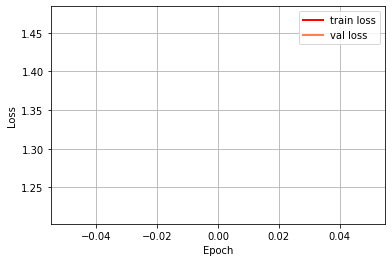

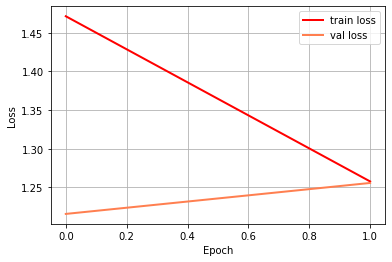

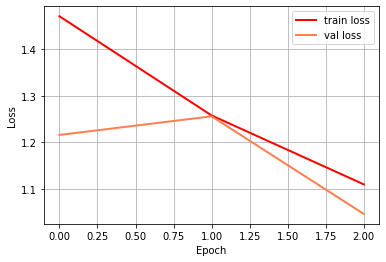

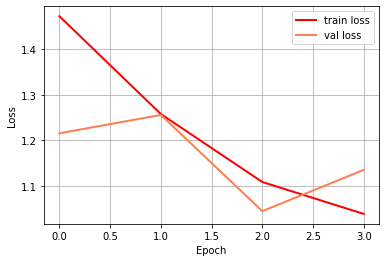

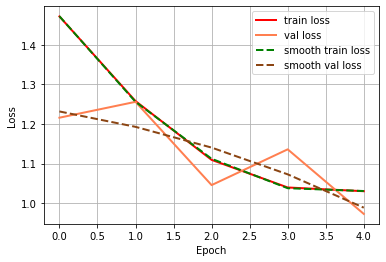

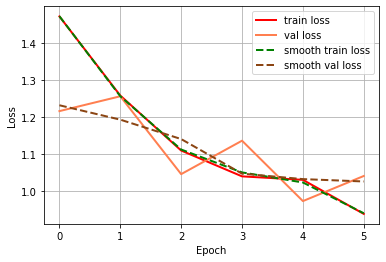

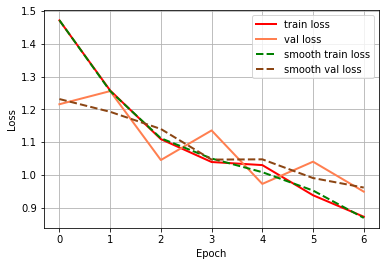

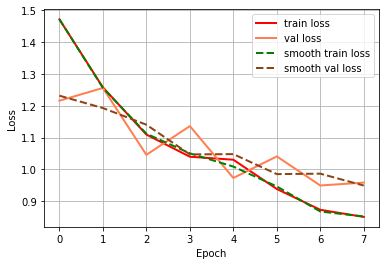

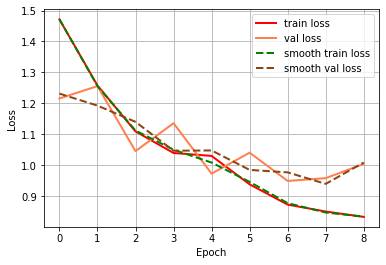

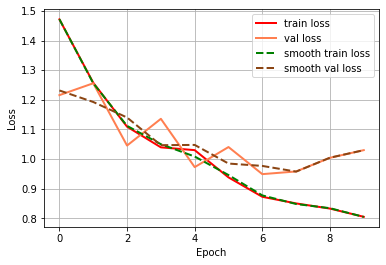

In [13]:
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm




def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def fit_ont_epoch(net,epoch,epoch_size,epoch_size_val,gen,genval,Epoch,cuda):
    total_loss = 0
    rpn_loc_loss = 0
    rpn_cls_loss = 0
    roi_loc_loss = 0
    roi_cls_loss = 0
    val_toal_loss = 0
    with tqdm(total=epoch_size,desc=f'Epoch {epoch + 1}/{Epoch}',postfix=dict,mininterval=0.3) as pbar:
        for iteration, batch in enumerate(gen):
            if iteration >= epoch_size:
                break
            imgs, boxes, labels = batch[0], batch[1], batch[2]
            with torch.no_grad():
                if cuda:
                    imgs = torch.from_numpy(imgs).type(torch.FloatTensor).cuda()
                else:
                    imgs = torch.from_numpy(imgs).type(torch.FloatTensor)

            losses = train_util.train_step(imgs, boxes, labels, 1)
            rpn_loc, rpn_cls, roi_loc, roi_cls, total = losses
            total_loss += total.item()
            rpn_loc_loss += rpn_loc.item()
            rpn_cls_loss += rpn_cls.item()
            roi_loc_loss += roi_loc.item()
            roi_cls_loss += roi_cls.item()
            
            pbar.set_postfix(**{'total'    : total_loss / (iteration + 1), 
                                'rpn_loc'  : rpn_loc_loss / (iteration + 1),  
                                'rpn_cls'  : rpn_cls_loss / (iteration + 1), 
                                'roi_loc'  : roi_loc_loss / (iteration + 1), 
                                'roi_cls'  : roi_cls_loss / (iteration + 1), 
                                'lr'       : get_lr(optimizer)})
            pbar.update(1)

    print('Start Validation')
    with tqdm(total=epoch_size_val, desc=f'Epoch {epoch + 1}/{Epoch}',postfix=dict,mininterval=0.3) as pbar:
        for iteration, batch in enumerate(genval):
            if iteration >= epoch_size_val:
                break
            imgs,boxes,labels = batch[0], batch[1], batch[2]
            with torch.no_grad():
                if cuda:
                    imgs = torch.from_numpy(imgs).type(torch.FloatTensor).cuda()
                else:
                    imgs = torch.from_numpy(imgs).type(torch.FloatTensor)

                train_util.optimizer.zero_grad()
                losses = train_util.forward(imgs, boxes, labels, 1)
                _, _, _, _, val_total = losses

                val_toal_loss += val_total.item()

            pbar.set_postfix(**{'total_loss': val_toal_loss / (iteration + 1)})
            pbar.update(1)

    loss_history.append_loss(total_loss/(epoch_size+1), val_toal_loss/(epoch_size_val+1))
    print('Finish Validation')
    print('Epoch:'+ str(epoch+1) + '/' + str(Epoch))
    print('Total Loss: %.4f || Val Loss: %.4f ' % (total_loss/(epoch_size+1),val_toal_loss/(epoch_size_val+1)))
    print('Saving state, iter:', str(epoch+1))
    torch.save(model.state_dict(), '/content/drive/MyDrive/FASTER-RCNN/logs/Epoch%d-Total_Loss%.4f-Val_Loss%.4f.pth'%((epoch+1),total_loss/(epoch_size+1),val_toal_loss/(epoch_size_val+1)))
    #只保存训练好的权重，不保存整个模型
if __name__ == "__main__":
    #-------------------------------#
    #   是否使用Cuda
    #   没有GPU可以设置成False
    #-------------------------------#
    Cuda = True
    #----------------------------------------------------#
    #   训练之前一定要修改NUM_CLASSES
    #   修改成所需要区分的类的个数。
    #----------------------------------------------------#
    NUM_CLASSES = 1
    #-------------------------------------------------------------------------------------#
    #   input_shape是输入图片的大小，默认为800,800,3，随着输入图片的增大，占用显存会增大
    #   视频上为600,600,3，实际测试中发现800,800,3效果更好
    #-------------------------------------------------------------------------------------#
    input_shape = [800,800,3]
    #----------------------------------------------------#
    #   使用到的主干特征提取网络
    #   vgg或者resnet50
    #----------------------------------------------------#
    backbone = "resnet50"
    model = FasterRCNN(NUM_CLASSES,backbone=backbone)
    weights_init(model)

    # #------------------------------------------------------#
    #   权值文件请看README，百度网盘下载
    #------------------------------------------------------#
    model_path = '/content/drive/MyDrive/FASTER-RCNN/model_data/voc_weights_resnet.pth'
    print('Loading weights into state dict...')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_path, map_location=device)
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if np.shape(model_dict[k]) ==  np.shape(v)}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    print('Finished!')

    net = model.train()
    if Cuda:
        net = torch.nn.DataParallel(model)
        cudnn.benchmark = True
        net = net.cuda()

    loss_history = LossHistory("logs/")

    annotation_path = '/content/drive/MyDrive/FASTER-RCNN/car_train.txt'
    #----------------------------------------------------------------------#
    #   验证集的划分在train.py代码里面进行
    #   2007_test.txt和2007_val.txt里面没有内容是正常的。训练不会使用到。
    #   当前划分方式下，验证集和训练集的比例为1:9
    #----------------------------------------------------------------------#
    val_split = 0.1
    with open(annotation_path) as f:
        lines = f.readlines()
    np.random.seed(10101)
    np.random.shuffle(lines)
    np.random.seed(None)
    num_val = int(len(lines)*val_split)
    num_train = len(lines) - num_val

    #------------------------------------------------------#
    #   主干特征提取网络特征通用，冻结训练可以加快训练速度
    #   也可以在训练初期防止权值被破坏。
    #   Init_Epoch为起始世代
    #   Freeze_Epoch为冻结训练的世代
    #   Epoch总训练世代
    #   提示OOM或者显存不足请调小Batch_size
    #------------------------------------------------------#
    if True:
        lr              = 1e-4
        Batch_size      = 2
        Init_Epoch      = 0
        Freeze_Epoch    = 5
        
        optimizer       = optim.Adam(net.parameters(), lr, weight_decay=5e-4)
        lr_scheduler    = optim.lr_scheduler.StepLR(optimizer,step_size=1,gamma=0.95)

        train_dataset   = FRCNNDataset(lines[:num_train], (input_shape[0], input_shape[1]), is_train=True)
        val_dataset     = FRCNNDataset(lines[num_train:], (input_shape[0], input_shape[1]), is_train=False)
        gen             = DataLoader(train_dataset, shuffle=True, batch_size=Batch_size, num_workers=4, pin_memory=True,
                                drop_last=True, collate_fn=frcnn_dataset_collate)
        gen_val         = DataLoader(val_dataset, shuffle=True, batch_size=Batch_size, num_workers=4, pin_memory=True,
                                drop_last=True, collate_fn=frcnn_dataset_collate)
                        
        epoch_size      = num_train // Batch_size
        epoch_size_val  = num_val // Batch_size

        if epoch_size == 0 or epoch_size_val == 0:
            raise ValueError("数据集过小，无法进行训练，请扩充数据集。")

        # ------------------------------------#
        #   冻结一定部分训练
        # ------------------------------------#
        for param in model.extractor.parameters():
            param.requires_grad = False

        # ------------------------------------#
        #   冻结bn层
        # ------------------------------------#
        model.freeze_bn()

        train_util      = FasterRCNNTrainer(model, optimizer)

        for epoch in range(Init_Epoch,Freeze_Epoch):
            fit_ont_epoch(net,epoch,epoch_size,epoch_size_val,gen,gen_val,Freeze_Epoch,Cuda)
            lr_scheduler.step()

    if True:
        lr              = 1e-5
        Batch_size      = 2
        Freeze_Epoch    = 5
        Unfreeze_Epoch  = 10

        optimizer       = optim.Adam(net.parameters(), lr, weight_decay=5e-4)
        lr_scheduler    = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

        train_dataset   = FRCNNDataset(lines[:num_train], (input_shape[0], input_shape[1]), is_train=True)
        val_dataset     = FRCNNDataset(lines[num_train:], (input_shape[0], input_shape[1]), is_train=False)
        gen             = DataLoader(train_dataset, shuffle=True, batch_size=Batch_size, num_workers=4, pin_memory=True,
                                drop_last=True, collate_fn=frcnn_dataset_collate)
        gen_val         = DataLoader(val_dataset, shuffle=True, batch_size=Batch_size, num_workers=4, pin_memory=True,
                                drop_last=True, collate_fn=frcnn_dataset_collate)
                        
        epoch_size      = num_train // Batch_size
        epoch_size_val  = num_val // Batch_size
        
        if epoch_size == 0 or epoch_size_val == 0:
            raise ValueError("数据集过小，无法进行训练，请扩充数据集。")
            
        #------------------------------------#
        #   解冻后训练
        #------------------------------------#
        for param in model.extractor.parameters():
            param.requires_grad = True

        # ------------------------------------#
        #   冻结bn层
        # ------------------------------------#
        model.freeze_bn()

        train_util      = FasterRCNNTrainer(model,optimizer)

        for epoch in range(Freeze_Epoch,Unfreeze_Epoch):
            fit_ont_epoch(net,epoch,epoch_size,epoch_size_val,gen,gen_val,Unfreeze_Epoch,Cuda)
            lr_scheduler.step()

# predict

In [16]:
import colorsys
import copy
import os
import time

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont


#--------------------------------------------#
#   使用自己训练好的模型预测需要修改2个参数
#   model_path和classes_path都需要修改！
#   如果出现shape不匹配
#   一定要注意训练时的NUM_CLASSES、
#   model_path和classes_path参数的修改
#--------------------------------------------#
class FRCNN(object):
    _defaults = {
        "model_path"    : '/content/drive/MyDrive/FASTER-RCNN/logs/Epoch10-Total_Loss0.8051-Val_Loss1.0301.pth', #logs/ epoch27...
        "classes_path"  : '/content/drive/MyDrive/FASTER-RCNN/model_data/voc_classes.txt', #class, add a txt file with licence
        "confidence"    : 0.5,
        "iou"           : 0.3,
        "backbone"      : "resnet50",
        "cuda"          : True,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    #---------------------------------------------------#
    #   初始化faster RCNN
    #---------------------------------------------------#
    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults)
        self.class_names = self._get_class()
        self.generate()

        self.mean = torch.Tensor([0, 0, 0, 0]).repeat(self.num_classes+1)[None]
        self.std = torch.Tensor([0.1, 0.1, 0.2, 0.2]).repeat(self.num_classes+1)[None]
        if self.cuda:
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()
            
        self.decodebox = DecodeBox(self.std, self.mean, self.num_classes)

    #---------------------------------------------------#
    #   获得所有的分类
    #---------------------------------------------------#
    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    #---------------------------------------------------#
    #   载入模型
    #---------------------------------------------------#
    def generate(self):
        #-------------------------------#
        #   计算总的类的数量
        #-------------------------------#
        self.num_classes = len(self.class_names)

        #-------------------------------#
        #   载入模型与权值
        #-------------------------------#
        self.model = FasterRCNN(self.num_classes,"predict",backbone=self.backbone).eval()
        print('Loading weights into state dict...')
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        state_dict = torch.load(self.model_path, map_location=device)
        self.model.load_state_dict(state_dict)
        
        if self.cuda:
            # self.model = nn.DataParallel(self.model)
            self.model = self.model.cuda()

        print('{} model, anchors, and classes loaded.'.format(self.model_path))

        # 画框设置不同的颜色
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        #self.colors = map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples)
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        #self.colors = map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),self.colors)
    #---------------------------------------------------#
    #   检测图片
    #---------------------------------------------------#
    def detect_image(self, image):
        #-------------------------------------#
        #   转换成RGB图片，可以用于灰度图预测。
        #-------------------------------------#
        image = image.convert("RGB")
        
        image_shape = np.array(np.shape(image)[0:2])
        old_width, old_height = image_shape[1], image_shape[0]
        old_image = copy.deepcopy(image)
        
        #---------------------------------------------------------#
        #   给原图像进行resize，resize到短边为600的大小上
        #---------------------------------------------------------#
        width,height = get_new_img_size(old_width, old_height)
        image = image.resize([width,height], Image.BICUBIC)

        #-----------------------------------------------------------#
        #   图片预处理，归一化。
        #-----------------------------------------------------------#
        photo = np.transpose(np.array(image,dtype = np.float32)/255, (2, 0, 1))

        with torch.no_grad():
            images = torch.from_numpy(np.asarray([photo]))
            if self.cuda:
                images = images.cuda()

            roi_cls_locs, roi_scores, rois, _ = self.model(images)
            #-------------------------------------------------------------#
            #   利用classifier的预测结果对建议框进行解码，获得预测框
            #-------------------------------------------------------------#
            outputs = self.decodebox.forward(roi_cls_locs[0], roi_scores[0], rois, height = height, width = width, nms_iou = self.iou, score_thresh = self.confidence)
            #---------------------------------------------------------#
            #   如果没有检测出物体，返回原图
            #---------------------------------------------------------#
            if len(outputs)==0:
                return old_image
            outputs = np.array(outputs)
            bbox = outputs[:,:4]
            label = outputs[:, 4]
            conf = outputs[:, 5]

            bbox[:, 0::2] = (bbox[:, 0::2]) / width * old_width
            bbox[:, 1::2] = (bbox[:, 1::2]) / height * old_height

        font = ImageFont.truetype(font='/content/drive/MyDrive/FASTER-RCNN/model_data/simhei.ttf',size=np.floor(3e-2 * np.shape(image)[1] + 0.5).astype('int32'))

        thickness = max((np.shape(old_image)[0] + np.shape(old_image)[1]) // old_width * 2, 1)
                
        image = old_image
        for i, c in enumerate(label):
            predicted_class = self.class_names[int(c)]
            score = conf[i]

            left, top, right, bottom = bbox[i]
            top = top - 5
            left = left - 5
            bottom = bottom + 5
            right = right + 5

            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(np.shape(image)[0], np.floor(bottom + 0.5).astype('int32'))
            right = min(np.shape(image)[1], np.floor(right + 0.5).astype('int32'))

            # 画框框
            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)
            label = label.encode('utf-8')
            print(label, top, left, bottom, right)
            
            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[int(c)])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[int(c)])
            draw.text(text_origin, str(label,'UTF-8'), fill=(0, 0, 0), font=font)
            del draw
        
        return image

    def get_FPS(self, image, test_interval):
        #-------------------------------------#
        #   转换成RGB图片，可以用于灰度图预测。
        #-------------------------------------#
        image = image.convert("RGB")

        image_shape = np.array(np.shape(image)[0:2])
        old_width, old_height = image_shape[1], image_shape[0]
        
        #---------------------------------------------------------#
        #   给原图像进行resize，resize到短边为600的大小上
        #---------------------------------------------------------#
        width,height = get_new_img_size(old_width, old_height)
        image = image.resize([width,height], Image.BICUBIC)

        #-----------------------------------------------------------#
        #   图片预处理，归一化。
        #-----------------------------------------------------------#
        photo = np.transpose(np.array(image,dtype = np.float32)/255, (2, 0, 1))

        with torch.no_grad():
            images = torch.from_numpy(np.asarray([photo]))
            if self.cuda:
                images = images.cuda()

            roi_cls_locs, roi_scores, rois, _ = self.model(images)
            #-------------------------------------------------------------#
            #   利用classifier的预测结果对建议框进行解码，获得预测框
            #-------------------------------------------------------------#
            outputs = self.decodebox.forward(roi_cls_locs[0], roi_scores[0], rois, height = height, width = width, nms_iou = self.iou, score_thresh = self.confidence)
            #---------------------------------------------------------#
            #   如果没有检测出物体，返回原图
            #---------------------------------------------------------#
            if len(outputs)>0:
                outputs = np.array(outputs)
                bbox = outputs[:,:4]
                label = outputs[:, 4]
                conf = outputs[:, 5]

                bbox[:, 0::2] = (bbox[:, 0::2]) / width * old_width
                bbox[:, 1::2] = (bbox[:, 1::2]) / height * old_height
                    
        t1 = time.time()
        for _ in range(test_interval):
            with torch.no_grad():
                roi_cls_locs, roi_scores, rois, _ = self.model(images)
                #-------------------------------------------------------------#
                #   利用classifier的预测结果对建议框进行解码，获得预测框
                #-------------------------------------------------------------#
                outputs = self.decodebox.forward(roi_cls_locs[0], roi_scores[0], rois, height = height, width = width, nms_iou = self.iou, score_thresh = self.confidence)
                #---------------------------------------------------------#
                #   如果没有检测出物体，返回原图
                #---------------------------------------------------------#
                if len(outputs)>0:
                    outputs = np.array(outputs)
                    bbox = outputs[:,:4]
                    label = outputs[:, 4]
                    conf = outputs[:, 5]

                    bbox[:, 0::2] = (bbox[:, 0::2]) / width * old_width
                    bbox[:, 1::2] = (bbox[:, 1::2]) / height * old_height
                
        t2 = time.time()
        tact_time = (t2 - t1) / test_interval
        return tact_time


In [17]:
#----------------------------------------------------#
#   对视频中的predict.py进行了修改，
#   将单张图片预测、摄像头检测和FPS测试功能
#   整合到了一个py文件中，通过指定mode进行模式的修改。
#----------------------------------------------------#
import time

import cv2
import numpy as np
from PIL import Image


if __name__ == "__main__":
    frcnn = FRCNN()
    #-------------------------------------------------------------------------#
    #   mode用于指定测试的模式：
    #   'predict'表示单张图片预测
    #   'video'表示视频检测
    #   'fps'表示测试fps
    #-------------------------------------------------------------------------#
    mode = "predict"
    #-------------------------------------------------------------------------#
    #   video_path用于指定视频的路径，当video_path=0时表示检测摄像头
    #   video_save_path表示视频保存的路径，当video_save_path=""时表示不保存
    #   video_fps用于保存的视频的fps
    #   video_path、video_save_path和video_fps仅在mode='video'时有效
    #   保存视频时需要ctrl+c退出才会完成完整的保存步骤，不可直接结束程序。
    #-------------------------------------------------------------------------#
    video_path      = 0
    video_save_path = ""
    video_fps       = 25.0

    if mode == "predict":
        '''
        1、该代码无法直接进行批量预测，如果想要批量预测，可以利用os.listdir()遍历文件夹，利用Image.open打开图片文件进行预测。
        具体流程可以参考get_dr_txt.py，在get_dr_txt.py即实现了遍历还实现了目标信息的保存。
        2、如果想要进行检测完的图片的保存，利用r_image.save("img.jpg")即可保存，直接在predict.py里进行修改即可。 
        3、如果想要获得预测框的坐标，可以进入frcnn.detect_image函数，在绘图部分读取top，left，bottom，right这四个值。
        4、如果想要利用预测框截取下目标，可以进入frcnn.detect_image函数，在绘图部分利用获取到的top，left，bottom，right这四个值
        在原图上利用矩阵的方式进行截取。
        5、如果想要在预测图上写额外的字，比如检测到的特定目标的数量，可以进入frcnn.detect_image函数，在绘图部分对predicted_class进行判断，
        比如判断if predicted_class == 'car': 即可判断当前目标是否为车，然后记录数量即可。利用draw.text即可写字。
        '''
        while True:
            img = input('Input image filename:')
            try:
                image = Image.open(img)
            except:
                print('Open Error! Try again!')
                continue
            else:
                r_image = frcnn.detect_image(image)
                r_image.show()

    elif mode == "video":
        capture=cv2.VideoCapture(video_path)
        if video_save_path!="":
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            size = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
            out = cv2.VideoWriter(video_save_path, fourcc, video_fps, size)

        fps = 0.0
        while(True):
            t1 = time.time()
            # 读取某一帧
            ref,frame=capture.read()
            # 格式转变，BGRtoRGB
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            # 转变成Image
            frame = Image.fromarray(np.uint8(frame))
            # 进行检测
            frame = np.array(frcnn.detect_image(frame))
            # RGBtoBGR满足opencv显示格式
            frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
            
            fps  = ( fps + (1./(time.time()-t1)) ) / 2
            print("fps= %.2f"%(fps))
            frame = cv2.putText(frame, "fps= %.2f"%(fps), (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow("video",frame)
            c= cv2.waitKey(1) & 0xff 
            if video_save_path!="":
                out.write(frame)

            if c==27:
                capture.release()
                break
        capture.release()
        out.release()
        cv2.destroyAllWindows()

    elif mode == "fps":
        test_interval = 100
        img = Image.open('/content/drive/MyDrive/FASTER-RCNN/VOC/JPEGImages/Cars85.png')
        tact_time = frcnn.get_FPS(img, test_interval)
        print(str(tact_time) + ' seconds, ' + str(1/tact_time) + 'FPS, @batch_size 1')
    else:
        raise AssertionError("Please specify the correct mode: 'predict', 'video' or 'fps'.")


Loading weights into state dict...
/content/drive/MyDrive/FASTER-RCNN/logs/Epoch10-Total_Loss0.8051-Val_Loss1.0301.pth model, anchors, and classes loaded.
Input image filename:/content/drive/MyDrive/FASTER-RCNN/VOC/JPEGImages/Cars85.png
b'licence 0.99' 207 79 235 151
b'licence 0.81' 115 311 142 368


KeyboardInterrupt: ignored

# mAP

In [18]:
#----------------------------------------------------#
#   获取测试集的ground-truth
#   具体视频教程可查看
#   https://www.bilibili.com/video/BV1zE411u7Vw
#----------------------------------------------------#
import glob
import os
import sys
import xml.etree.ElementTree as ET

#'''
#！！！！！！！！！！！！！注意事项！！！！！！！！！！！！！
# 这一部分是当xml有无关的类的时候，下方有代码可以进行筛选！
#'''
#---------------------------------------------------#
#   获得类
#---------------------------------------------------#
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

image_ids = open('/content/drive/MyDrive/FASTER-RCNN/VOC/ImageSets/Main/test.txt').read().strip().split()

if not os.path.exists("/content/drive/MyDrive/FASTER-RCNN/input"):
    os.makedirs("/content/drive/MyDrive/FASTER-RCNN/input")
if not os.path.exists("/content/drive/MyDrive/FASTER-RCNN/input/ground-truth"):
    os.makedirs("/content/drive/MyDrive/FASTER-RCNN/input/ground-truth")

for image_id in image_ids:
    with open("/content/drive/MyDrive/FASTER-RCNN/input/ground-truth/"+image_id+".txt", "w") as new_f:
        root = ET.parse("/content/drive/MyDrive/FASTER-RCNN/VOC/Annotations/"+image_id+".xml").getroot()
        for obj in root.findall('object'):
            difficult_flag = False
            if obj.find('difficult')!=None:
                difficult = obj.find('difficult').text
                if int(difficult)==1:
                    difficult_flag = True
            obj_name = obj.find('name').text
            #'''
            #！！！！！！！！！！！！注意事项！！！！！！！！！！！！
            # 这一部分是当xml有无关的类的时候，可以取消下面代码的注释
            # 利用对应的classes.txt来进行筛选！！！！！！！！！！！！
            #'''
            # classes_path = 'model_data/voc_classes.txt'
            # class_names = get_classes(classes_path)
            # if obj_name not in class_names:
            #     continue

            bndbox = obj.find('bndbox')
            left = bndbox.find('xmin').text
            top = bndbox.find('ymin').text
            right = bndbox.find('xmax').text
            bottom = bndbox.find('ymax').text

            if difficult_flag:
                new_f.write("%s %s %s %s %s difficult\n" % (obj_name, left, top, right, bottom))
            else:
                new_f.write("%s %s %s %s %s\n" % (obj_name, left, top, right, bottom))

print("Conversion completed!")


Conversion completed!


In [21]:
#----------------------------------------------------#
#   获取测试集的detection-result和images-optional
#   具体视频教程可查看
#   https://www.bilibili.com/video/BV1zE411u7Vw
#----------------------------------------------------#
import copy
import os

import numpy as np
import torch
from PIL import Image
from tqdm import tqdm



#'''
#这里设置的门限值较低是因为计算map需要用到不同门限条件下的Recall和Precision值。
#所以只有保留的框足够多，计算的map才会更精确，详情可以了解map的原理。
#计算map时输出的Recall和Precision值指的是门限为0.5时的Recall和Precision值。

#此处获得的./input/detection-results/里面的txt的框的数量会比直接predict多一些，这是因为这里的门限低，
#目的是为了计算不同门限条件下的Recall和Precision值，从而实现map的计算。

#这里的self.iou指的是非极大抑制所用到的iou，具体的可以了解非极大抑制的原理，
#如果低分框与高分框的iou大于这里设定的self.iou，那么该低分框将会被剔除。

#可能有些同学知道有0.5和0.5:0.95的mAP，这里的self.iou=0.5不代表mAP0.5。
#如果想要设定mAP0.x，比如设定mAP0.75，可以去get_map.py设定MINOVERLAP。
#'''
class mAP_FRCNN(FRCNN):
    #---------------------------------------------------#
    #   检测图片
    #---------------------------------------------------#
    def detect_image(self,image_id,image):
        self.confidence = 0.01
        self.iou        = 0.45
        f = open("C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/detection-results/"+image_id+".txt","w") 
        #-------------------------------------#
        #   转换成RGB图片，可以用于灰度图预测。
        #-------------------------------------#
        image = image.convert("RGB")

        image_shape = np.array(np.shape(image)[0:2])
        old_width, old_height = image_shape[1], image_shape[0]
        old_image = copy.deepcopy(image)
        
        #---------------------------------------------------------#
        #   给原图像进行resize，resize到短边为600的大小上
        #---------------------------------------------------------#
        width,height = get_new_img_size(old_width, old_height)
        image = image.resize([width,height], Image.BICUBIC)

        #-----------------------------------------------------------#
        #   图片预处理，归一化。
        #-----------------------------------------------------------#
        photo = np.transpose(np.array(image,dtype = np.float32)/255, (2, 0, 1))

        with torch.no_grad():
            images = torch.from_numpy(np.asarray([photo]))
            if self.cuda:
                images = images.cuda()

            roi_cls_locs, roi_scores, rois, _ = self.model(images)

            #-------------------------------------------------------------#
            #   利用classifier的预测结果对建议框进行解码，获得预测框
            #-------------------------------------------------------------#
            outputs = self.decodebox.forward(roi_cls_locs[0], roi_scores[0], rois, height = height, width = width, nms_iou = self.iou, score_thresh = self.confidence)
            #---------------------------------------------------------#
            #   如果没有检测出物体，返回原图
            #---------------------------------------------------------#
            if len(outputs)==0:
                return old_image
            outputs = np.array(outputs)
            bbox = outputs[:,:4]
            label = outputs[:, 4]
            conf = outputs[:, 5]

            bbox[:, 0::2] = (bbox[:, 0::2]) / width * old_width
            bbox[:, 1::2] = (bbox[:, 1::2]) / height * old_height
            
        for i, c in enumerate(label):
            predicted_class = self.class_names[int(c)]
            score = str(conf[i])

            left, top, right, bottom = bbox[i]
            f.write("%s %s %s %s %s %s\n" % (predicted_class, score[:6], str(int(left)), str(int(top)), str(int(right)),str(int(bottom))))

        f.close()
        return 

fffrcnn = mAP_FRCNN()
image_ids = open('C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/VOC/ImageSets/Main/test.txt').read().strip().split()

if not os.path.exists("C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/input"):
    os.makedirs("C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/input")
if not os.path.exists("C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/input/detection-results"):
    os.makedirs("C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/input/detection-results")
if not os.path.exists("C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/input/Images-optional"):
    os.makedirs("C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/input/Images-optional")

for image_id in tqdm(image_ids):
    image_path = "C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/VOC/JPEGImages/"+image_id+".png"
    image = Image.open(image_path)
    image = image.convert("RGB")
    image.save("C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/input/Images-optional/"+image_id+".png")
    fffrcnn.detect_image(image_id,image)
    
print("Conversion completed!")


Loading weights into state dict...
/content/drive/MyDrive/FASTER-RCNN/logs/Epoch10-Total_Loss0.8051-Val_Loss1.0301.pth model, anchors, and classes loaded.


100%|██████████| 44/44 [00:52<00:00,  1.20s/it]

Conversion completed!


In [6]:
import glob
import json
import os
import shutil
import operator
import sys
import argparse
import math
import cv2
import numpy as np
#from google.colab.patches import cv2_imshow


#'''
#用于计算mAP
#代码克隆自https://github.com/Cartucho/mAP
#如果想要设定mAP0.x，比如计算mAP0.75，可以设定MINOVERLAP = 0.75。
#'''
MINOVERLAP = 0.5

parser = argparse.ArgumentParser()
parser.add_argument('-na', '--no-animation', help="no animation is shown.", action="store_true")
parser.add_argument('-np', '--no-plot', help="no plot is shown.", action="store_true")
parser.add_argument('-q', '--quiet', help="minimalistic console output.", action="store_true")
parser.add_argument('-i', '--ignore', nargs='+', type=str, help="ignore a list of classes.")
parser.add_argument('--set-class-iou', nargs='+', type=str, help="set IoU for a specific class.")
#args = parser.parse_args()
args, unknown = parser.parse_known_args()

#'''
#    0,0 ------> x (width)
#     |
#     |  (Left,Top)
#     |      *_________
#     |      |         |
#            |         |
#     y      |_________|
#  (height)            *
#                (Right,Bottom)
#'''

if args.ignore is None:
    args.ignore = []

specific_iou_flagged = False
if args.set_class_iou is not None:
    specific_iou_flagged = True

#os.chdir(os.path.dirname(os.path.abspath(__file__)))

GT_PATH = os.path.join('C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/input/ground-truth')
DR_PATH = os.path.join('C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/input/detection-results')
IMG_PATH = os.path.join('C:/Users/daye/Downloads/FASTER-RCNN-20210828T094248Z-001/FASTER-RCNN/input/Images-optional')
if os.path.exists(IMG_PATH): 
    for dirpath, dirnames, files in os.walk(IMG_PATH):
        if not files:
            args.no_animation = True
else:
    args.no_animation = True

show_animation = False
if not args.no_animation:
    try:
        import cv2
        show_animation = True
    except ImportError:
        print("\"opencv-python\" not found, please install to visualize the results.")
        args.no_animation = True

draw_plot = False
if not args.no_plot:
    try:
        import matplotlib.pyplot as plt
        draw_plot = True
    except ImportError:
        print("\"matplotlib\" not found, please install it to get the resulting plots.")
        args.no_plot = True


def log_average_miss_rate(precision, fp_cumsum, num_images):
#    """
#        log-average miss rate:
#            Calculated by averaging miss rates at 9 evenly spaced FPPI points
#            between 10e-2 and 10e0, in log-space.

#        output:
#                lamr | log-average miss rate
#                mr | miss rate
#                fppi | false positives per image

#       references:
#           [1] Dollar, Piotr, et al. "Pedestrian Detection: An Evaluation of the
#              State of the Art." Pattern Analysis and Machine Intelligence, IEEE
#              Transactions on 34.4 (2012): 743 - 761.
#    """

    if precision.size == 0:
        lamr = 0
        mr = 1
        fppi = 0
        return lamr, mr, fppi

    fppi = fp_cumsum / float(num_images)
    mr = (1 - precision)

    fppi_tmp = np.insert(fppi, 0, -1.0)
    mr_tmp = np.insert(mr, 0, 1.0)

    ref = np.logspace(-2.0, 0.0, num = 9)
    for i, ref_i in enumerate(ref):
        j = np.where(fppi_tmp <= ref_i)[-1][-1]
        ref[i] = mr_tmp[j]

    lamr = math.exp(np.mean(np.log(np.maximum(1e-10, ref))))

    return lamr, mr, fppi

#"""
# throw error and exit
#"""
def error(msg):
    print(msg)
    sys.exit(0)

#"""
# check if the number is a float between 0.0 and 1.0
#"""
def is_float_between_0_and_1(value):
    try:
        val = float(value)
        if val > 0.0 and val < 1.0:
            return True
        else:
            return False
    except ValueError:
        return False

#"""
# Calculate the AP given the recall and precision array
#    1st) We compute a version of the measured precision/recall curve with
#        precision monotonically decreasing
#    2nd) We compute the AP as the area under this curve by numerical integration.
#"""
def voc_ap(rec, prec):
#    """
 #   --- Official matlab code VOC2012---
#    mrec=[0 ; rec ; 1];
#    mpre=[0 ; prec ; 0];
#    for i=numel(mpre)-1:-1:1
#            mpre(i)=max(mpre(i),mpre(i+1));
#    end
#    i=find(mrec(2:end)~=mrec(1:end-1))+1;
#    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
#    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
#    """
#     This part makes the precision monotonically decreasing
#        (goes from the end to the beginning)
#        matlab: for i=numel(mpre)-1:-1:1
#                    mpre(i)=max(mpre(i),mpre(i+1));
#    """
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
 #   """
 #    This part creates a list of indexes where the recall changes
 #       matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
 #   """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
 #   """
 #    The Average Precision (AP) is the area under the curve
 #       (numerical integration)
 #       matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
 #   """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre


#"""
# Convert the lines of a file to a list
#"""
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]
    return content

#"""
# Draws text in image
#"""
def draw_text_in_image(img, text, pos, color, line_width):
    font = cv2.FONT_HERSHEY_PLAIN
    fontScale = 1
    lineType = 1
    bottomLeftCornerOfText = pos
    cv2.putText(img, text,
            bottomLeftCornerOfText,
            font,
            fontScale,
            color,
            lineType)
    text_width, _ = cv2.getTextSize(text, font, fontScale, lineType)[0]
    return img, (line_width + text_width)

#"""
# Plot - adjust axes
#"""
def adjust_axes(r, t, fig, axes):
    # get text width for re-scaling
    bb = t.get_window_extent(renderer=r)
    text_width_inches = bb.width / fig.dpi
    # get axis width in inches
    current_fig_width = fig.get_figwidth()
    new_fig_width = current_fig_width + text_width_inches
    propotion = new_fig_width / current_fig_width
    # get axis limit
    x_lim = axes.get_xlim()
    axes.set_xlim([x_lim[0], x_lim[1]*propotion])

#"""
# Draw plot using Matplotlib
#"""
def draw_plot_func(dictionary, n_classes, window_title, plot_title, x_label, output_path, to_show, plot_color, true_p_bar):
    # sort the dictionary by decreasing value, into a list of tuples
    sorted_dic_by_value = sorted(dictionary.items(), key=operator.itemgetter(1))
    # unpacking the list of tuples into two lists
    sorted_keys, sorted_values = zip(*sorted_dic_by_value)
    # 
    if true_p_bar != "":
#        """
#         Special case to draw in:
#            - green -> TP: True Positives (object detected and matches ground-truth)
#            - red -> FP: False Positives (object detected but does not match ground-truth)
#            - orange -> FN: False Negatives (object not detected but present in the ground-truth)
#        """
        fp_sorted = []
        tp_sorted = []
        for key in sorted_keys:
            fp_sorted.append(dictionary[key] - true_p_bar[key])
            tp_sorted.append(true_p_bar[key])
        plt.barh(range(n_classes), fp_sorted, align='center', color='crimson', label='False Positive')
        plt.barh(range(n_classes), tp_sorted, align='center', color='forestgreen', label='True Positive', left=fp_sorted)
        # add legend
        plt.legend(loc='lower right')
#        """
#         Write number on side of bar
#        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            fp_val = fp_sorted[i]
            tp_val = tp_sorted[i]
            fp_str_val = " " + str(fp_val)
            tp_str_val = fp_str_val + " " + str(tp_val)
            # trick to paint multicolor with offset:
            # first paint everything and then repaint the first number
            t = plt.text(val, i, tp_str_val, color='forestgreen', va='center', fontweight='bold')
            plt.text(val, i, fp_str_val, color='crimson', va='center', fontweight='bold')
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    else:
        plt.barh(range(n_classes), sorted_values, color=plot_color)
#        """
#         Write number on side of bar
#        """
        fig = plt.gcf() # gcf - get current figure
        axes = plt.gca()
        r = fig.canvas.get_renderer()
        for i, val in enumerate(sorted_values):
            str_val = " " + str(val) # add a space before
            if val < 1.0:
                str_val = " {0:.2f}".format(val)
            t = plt.text(val, i, str_val, color=plot_color, va='center', fontweight='bold')
            # re-set axes to show number inside the figure
            if i == (len(sorted_values)-1): # largest bar
                adjust_axes(r, t, fig, axes)
    # set window title
    fig.canvas.set_window_title(window_title)
    # write classes in y axis
    tick_font_size = 12
    plt.yticks(range(n_classes), sorted_keys, fontsize=tick_font_size)
#    """
#     Re-scale height accordingly
#    """
    init_height = fig.get_figheight()
    # comput the matrix height in points and inches
    dpi = fig.dpi
    height_pt = n_classes * (tick_font_size * 1.4) # 1.4 (some spacing)
    height_in = height_pt / dpi
    # compute the required figure height 
    top_margin = 0.15 # in percentage of the figure height
    bottom_margin = 0.05 # in percentage of the figure height
    figure_height = height_in / (1 - top_margin - bottom_margin)
    # set new height
    if figure_height > init_height:
        fig.set_figheight(figure_height)

    # set plot title
    plt.title(plot_title, fontsize=14)
    # set axis titles
    # plt.xlabel('classes')
    plt.xlabel(x_label, fontsize='large')
    # adjust size of window
    fig.tight_layout()
    # save the plot
    fig.savefig(output_path)
    # show image
    if to_show:
        plt.show()
    # close the plot
    plt.close()

#"""
# Create a ".temp_files/" and "results/" directory
#"""
TEMP_FILES_PATH = ".temp_files"
if not os.path.exists(TEMP_FILES_PATH): # if it doesn't exist already
    os.makedirs(TEMP_FILES_PATH)
results_files_path = "results"
if os.path.exists(results_files_path): # if it exist already
    # reset the results directory
    shutil.rmtree(results_files_path)

os.makedirs(results_files_path)
if draw_plot:
    os.makedirs(os.path.join(results_files_path, "AP"))
    os.makedirs(os.path.join(results_files_path, "F1"))
    os.makedirs(os.path.join(results_files_path, "Recall"))
    os.makedirs(os.path.join(results_files_path, "Precision"))
if show_animation:
    os.makedirs(os.path.join(results_files_path, "images", "detections_one_by_one"))

#"""
# ground-truth
#     Load each of the ground-truth files into a temporary ".json" file.
#     Create a list of all the class names present in the ground-truth (gt_classes).
#"""
# get a list with the ground-truth files
ground_truth_files_list = glob.glob(GT_PATH + '/*.txt')
if len(ground_truth_files_list) == 0:
    error("Error: No ground-truth files found!")
ground_truth_files_list.sort()
# dictionary with counter per class
gt_counter_per_class = {}
counter_images_per_class = {}

for txt_file in ground_truth_files_list:
    #print(txt_file)
    file_id = txt_file.split(".txt", 1)[0]
    file_id = os.path.basename(os.path.normpath(file_id))
    # check if there is a correspondent detection-results file
    temp_path = os.path.join(DR_PATH, (file_id + ".txt"))
    if not os.path.exists(temp_path):
        error_msg = "Error. File not found: {}\n".format(temp_path)
        error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
        error(error_msg)
    lines_list = file_lines_to_list(txt_file)
    # create ground-truth dictionary
    bounding_boxes = []
    is_difficult = False
    already_seen_classes = []
    for line in lines_list:
        try:
            if "difficult" in line:
                class_name, left, top, right, bottom, _difficult = line.split()
                is_difficult = True
            else:
                class_name, left, top, right, bottom = line.split()
                    
        except:
            if "difficult" in line:
                line_split = line.split()
                _difficult = line_split[-1]
                bottom = line_split[-2]
                right = line_split[-3]
                top = line_split[-4]
                left = line_split[-5]
                class_name = ""
                for name in line_split[:-5]:
                    class_name += name + " "
                class_name = class_name[:-1]
                is_difficult = True
            else:
                line_split = line.split()
                bottom = line_split[-1]
                right = line_split[-2]
                top = line_split[-3]
                left = line_split[-4]
                class_name = ""
                for name in line_split[:-4]:
                    class_name += name + " "
                class_name = class_name[:-1]
        if class_name in args.ignore:
            continue
        bbox = left + " " + top + " " + right + " " +bottom
        if is_difficult:
                bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False, "difficult":True})
                is_difficult = False
        else:
                bounding_boxes.append({"class_name":class_name, "bbox":bbox, "used":False})
                if class_name in gt_counter_per_class:
                    gt_counter_per_class[class_name] += 1
                else:
                    gt_counter_per_class[class_name] = 1

                if class_name not in already_seen_classes:
                    if class_name in counter_images_per_class:
                        counter_images_per_class[class_name] += 1
                    else:
                        counter_images_per_class[class_name] = 1
                    already_seen_classes.append(class_name)


    with open(TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json", 'w') as outfile:
        json.dump(bounding_boxes, outfile)

gt_classes = list(gt_counter_per_class.keys())
gt_classes = sorted(gt_classes)
n_classes = len(gt_classes)

#"""
# Check format of the flag --set-class-iou (if used)
#    e.g. check if class exists
#"""
if specific_iou_flagged:
    n_args = len(args.set_class_iou)
    error_msg = \
        '\n --set-class-iou [class_1] [IoU_1] [class_2] [IoU_2] [...]'
    if n_args % 2 != 0:
        error('Error, missing arguments. Flag usage:' + error_msg)
    # [class_1] [IoU_1] [class_2] [IoU_2]
    # specific_iou_classes = ['class_1', 'class_2']
    specific_iou_classes = args.set_class_iou[::2] # even
    # iou_list = ['IoU_1', 'IoU_2']
    iou_list = args.set_class_iou[1::2] # odd
    if len(specific_iou_classes) != len(iou_list):
        error('Error, missing arguments. Flag usage:' + error_msg)
    for tmp_class in specific_iou_classes:
        if tmp_class not in gt_classes:
                    error('Error, unknown class \"' + tmp_class + '\". Flag usage:' + error_msg)
    for num in iou_list:
        if not is_float_between_0_and_1(num):
            error('Error, IoU must be between 0.0 and 1.0. Flag usage:' + error_msg)

#"""
# detection-results
#     Load each of the detection-results files into a temporary ".json" file.
#"""
dr_files_list = glob.glob(DR_PATH + '/*.txt')
dr_files_list.sort()

for class_index, class_name in enumerate(gt_classes):
    bounding_boxes = []
    for txt_file in dr_files_list:
        file_id = txt_file.split(".txt",1)[0]
        file_id = os.path.basename(os.path.normpath(file_id))
        temp_path = os.path.join(GT_PATH, (file_id + ".txt"))
        if class_index == 0:
            if not os.path.exists(temp_path):
                error_msg = "Error. File not found: {}\n".format(temp_path)
                error_msg += "(You can avoid this error message by running extra/intersect-gt-and-dr.py)"
                error(error_msg)
        lines = file_lines_to_list(txt_file)
        for line in lines:
            try:
                tmp_class_name, confidence, left, top, right, bottom = line.split()
            except:
                line_split = line.split()
                bottom = line_split[-1]
                right = line_split[-2]
                top = line_split[-3]
                left = line_split[-4]
                confidence = line_split[-5]
                tmp_class_name = ""
                for name in line_split[:-5]:
                    tmp_class_name += name + " "
                tmp_class_name = tmp_class_name[:-1]

            if tmp_class_name == class_name:
                bbox = left + " " + top + " " + right + " " +bottom
                bounding_boxes.append({"confidence":confidence, "file_id":file_id, "bbox":bbox})

    bounding_boxes.sort(key=lambda x:float(x['confidence']), reverse=True)
    with open(TEMP_FILES_PATH + "/" + class_name + "_dr.json", 'w') as outfile:
        json.dump(bounding_boxes, outfile)

#"""
# Calculate the AP for each class
#"""
sum_AP = 0.0
ap_dictionary = {}
lamr_dictionary = {}
with open(results_files_path + "/results.txt", 'w') as results_file:
    results_file.write("# AP and precision/recall per class\n")
    count_true_positives = {}

    for class_index, class_name in enumerate(gt_classes):
        count_true_positives[class_name] = 0
        """
         Load detection-results of that class
        """
        dr_file = TEMP_FILES_PATH + "/" + class_name + "_dr.json"
        dr_data = json.load(open(dr_file))
        """
         Assign detection-results to ground-truth objects
        """
        nd = len(dr_data)
        tp = [0] * nd
        fp = [0] * nd
        score = [0] * nd
        score05_idx = 0
        for idx, detection in enumerate(dr_data):
            file_id = detection["file_id"]
            score[idx]   = float(detection["confidence"])
            if score[idx] > 0.5:
                score05_idx = idx

            if show_animation:
                ground_truth_img = glob.glob1(IMG_PATH, file_id + ".*")
                if len(ground_truth_img) == 0:
                    error("Error. Image not found with id: " + file_id)
                elif len(ground_truth_img) > 1:
                    error("Error. Multiple image with id: " + file_id)
                else:
                    img = cv2.imread(IMG_PATH + "/" + ground_truth_img[0])
                    img_cumulative_path = results_files_path + "/images/" + ground_truth_img[0]
                    if os.path.isfile(img_cumulative_path):
                        img_cumulative = cv2.imread(img_cumulative_path)
                    else:
                        img_cumulative = img.copy()
                    bottom_border = 60
                    BLACK = [0, 0, 0]
                    img = cv2.copyMakeBorder(img, 0, bottom_border, 0, 0, cv2.BORDER_CONSTANT, value=BLACK)

            gt_file = TEMP_FILES_PATH + "/" + file_id + "_ground_truth.json"
            ground_truth_data = json.load(open(gt_file))
            ovmax = -1
            gt_match = -1
            bb = [ float(x) for x in detection["bbox"].split() ]
            for obj in ground_truth_data:
                if obj["class_name"] == class_name:
                    bbgt = [ float(x) for x in obj["bbox"].split() ]
                    bi = [max(bb[0],bbgt[0]), max(bb[1],bbgt[1]), min(bb[2],bbgt[2]), min(bb[3],bbgt[3])]
                    iw = bi[2] - bi[0] + 1
                    ih = bi[3] - bi[1] + 1
                    if iw > 0 and ih > 0:
                        # compute overlap (IoU) = area of intersection / area of union
                        ua = (bb[2] - bb[0] + 1) * (bb[3] - bb[1] + 1) + (bbgt[2] - bbgt[0]
                                        + 1) * (bbgt[3] - bbgt[1] + 1) - iw * ih
                        ov = iw * ih / ua
                        if ov > ovmax:
                            ovmax = ov
                            gt_match = obj

            if show_animation:
                status = "NO MATCH FOUND!" 
            min_overlap = MINOVERLAP
            if specific_iou_flagged:
                if class_name in specific_iou_classes:
                    index = specific_iou_classes.index(class_name)
                    min_overlap = float(iou_list[index])
            if ovmax >= min_overlap:
                if "difficult" not in gt_match:
                    if not bool(gt_match["used"]):
                        tp[idx] = 1
                        gt_match["used"] = True
                        count_true_positives[class_name] += 1
                        with open(gt_file, 'w') as f:
                                f.write(json.dumps(ground_truth_data))
                        if show_animation:
                            status = "MATCH!"
                    else:
                        fp[idx] = 1
                        if show_animation:
                            status = "REPEATED MATCH!"
            else:
                fp[idx] = 1
                if ovmax > 0:
                    status = "INSUFFICIENT OVERLAP"

#            """
#             Draw image to show animation
#            """
            if show_animation:
                height, widht = img.shape[:2]
                # colors (OpenCV works with BGR)
                white = (255,255,255)
                light_blue = (255,200,100)
                green = (0,255,0)
                light_red = (30,30,255)
                # 1st line
                margin = 10
                v_pos = int(height - margin - (bottom_border / 2.0))
                text = "Image: " + ground_truth_img[0] + " "
                img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                text = "Class [" + str(class_index) + "/" + str(n_classes) + "]: " + class_name + " "
                img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), light_blue, line_width)
                if ovmax != -1:
                    color = light_red
                    if status == "INSUFFICIENT OVERLAP":
                        text = "IoU: {0:.2f}% ".format(ovmax*100) + "< {0:.2f}% ".format(min_overlap*100)
                    else:
                        text = "IoU: {0:.2f}% ".format(ovmax*100) + ">= {0:.2f}% ".format(min_overlap*100)
                        color = green
                    img, _ = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)
                # 2nd line
                v_pos += int(bottom_border / 2.0)
                rank_pos = str(idx+1) # rank position (idx starts at 0)
                text = "Detection #rank: " + rank_pos + " confidence: {0:.2f}% ".format(float(detection["confidence"])*100)
                img, line_width = draw_text_in_image(img, text, (margin, v_pos), white, 0)
                color = light_red
                if status == "MATCH!":
                    color = green
                text = "Result: " + status + " "
                img, line_width = draw_text_in_image(img, text, (margin + line_width, v_pos), color, line_width)

                font = cv2.FONT_HERSHEY_SIMPLEX
                if ovmax > 0: # if there is intersections between the bounding-boxes
                    bbgt = [ int(round(float(x))) for x in gt_match["bbox"].split() ]
                    cv2.rectangle(img,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                    cv2.rectangle(img_cumulative,(bbgt[0],bbgt[1]),(bbgt[2],bbgt[3]),light_blue,2)
                    cv2.putText(img_cumulative, class_name, (bbgt[0],bbgt[1] - 5), font, 0.6, light_blue, 1, cv2.LINE_AA)
                bb = [int(i) for i in bb]
                cv2.rectangle(img,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                cv2.rectangle(img_cumulative,(bb[0],bb[1]),(bb[2],bb[3]),color,2)
                cv2.putText(img_cumulative, class_name, (bb[0],bb[1] - 5), font, 0.6, color, 1, cv2.LINE_AA)
                # show image
                cv2.namedWindow("Animation")
                cv2.imshow("Animation", img)
                #cvShowImage('Animation',img)
                cv2.waitKey(20)# show for 20 ms
                #cv2.destroyAllWindows()
                # save image to results
                output_img_path = results_files_path + "/images/detections_one_by_one/" + class_name + "_detection" + str(idx) + ".jpg"
                cv2.imwrite(output_img_path, img)
                # save the image with all the objects drawn to it
                cv2.imwrite(img_cumulative_path, img_cumulative)

        cumsum = 0
        for idx, val in enumerate(fp):
            fp[idx] += cumsum
            cumsum += val

        cumsum = 0
        for idx, val in enumerate(tp):
            tp[idx] += cumsum
            cumsum += val

        rec = tp[:]
        for idx, val in enumerate(tp):
            rec[idx] = float(tp[idx]) / np.maximum(gt_counter_per_class[class_name], 1)

        prec = tp[:]
        for idx, val in enumerate(tp):
            prec[idx] = float(tp[idx]) / np.maximum((fp[idx] + tp[idx]), 1)

        ap, mrec, mprec = voc_ap(rec[:], prec[:])
        F1 = np.array(rec)*np.array(prec)*2 / np.where((np.array(prec)+np.array(rec))==0, 1, (np.array(prec)+np.array(rec)))

        sum_AP += ap
        text = "{0:.2f}%".format(ap*100) + " = " + class_name + " AP " #class_name + " AP = {0:.2f}%".format(ap*100)

        if len(prec)>0:
            F1_text = "{0:.2f}".format(F1[score05_idx]) + " = " + class_name + " F1 "
            Recall_text = "{0:.2f}%".format(rec[score05_idx]*100) + " = " + class_name + " Recall "
            Precision_text = "{0:.2f}%".format(prec[score05_idx]*100) + " = " + class_name + " Precision "
        else:
            F1_text = "0.00" + " = " + class_name + " F1 " 
            Recall_text = "0.00%" + " = " + class_name + " Recall " 
            Precision_text = "0.00%" + " = " + class_name + " Precision " 

        rounded_prec = [ '%.2f' % elem for elem in prec ]
        rounded_rec = [ '%.2f' % elem for elem in rec ]
        results_file.write(text + "\n Precision: " + str(rounded_prec) + "\n Recall :" + str(rounded_rec) + "\n\n")
        if not args.quiet:
            if len(prec)>0:
                print(text + "\t||\tscore_threhold=0.5 : " + "F1=" + "{0:.2f}".format(F1[score05_idx])\
                    + " ; Recall=" + "{0:.2f}%".format(rec[score05_idx]*100) + " ; Precision=" + "{0:.2f}%".format(prec[score05_idx]*100))
            else:
                print(text + "\t||\tscore_threhold=0.5 : F1=0.00% ; Recall=0.00% ; Precision=0.00%")
        ap_dictionary[class_name] = ap

        n_images = counter_images_per_class[class_name]
        lamr, mr, fppi = log_average_miss_rate(np.array(rec), np.array(fp), n_images)
        lamr_dictionary[class_name] = lamr

#        """
#         Draw plot
#        """
        if draw_plot:
            plt.plot(rec, prec, '-o')
            area_under_curve_x = mrec[:-1] + [mrec[-2]] + [mrec[-1]]
            area_under_curve_y = mprec[:-1] + [0.0] + [mprec[-1]]
            plt.fill_between(area_under_curve_x, 0, area_under_curve_y, alpha=0.2, edgecolor='r')

            fig = plt.gcf()
            fig.canvas.set_window_title('AP ' + class_name)

            plt.title('class: ' + text)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            axes = plt.gca()
            axes.set_xlim([0.0,1.0])
            axes.set_ylim([0.0,1.05]) 
            fig.savefig(results_files_path + "/AP/" + class_name + ".png")
            plt.cla()

            plt.plot(score, F1, "-", color='orangered')
            plt.title('class: ' + F1_text + "\nscore_threhold=0.5")
            plt.xlabel('Score_Threhold')
            plt.ylabel('F1')
            axes = plt.gca()
            axes.set_xlim([0.0,1.0])
            axes.set_ylim([0.0,1.05])
            fig.savefig(results_files_path + "/F1/" + class_name + ".png")
            plt.cla()

            plt.plot(score, rec, "-H", color='gold')
            plt.title('class: ' + Recall_text + "\nscore_threhold=0.5")
            plt.xlabel('Score_Threhold')
            plt.ylabel('Recall')
            axes = plt.gca()
            axes.set_xlim([0.0,1.0])
            axes.set_ylim([0.0,1.05])
            fig.savefig(results_files_path + "/Recall/" + class_name + ".png")
            plt.cla()

            plt.plot(score, prec, "-s", color='palevioletred')
            plt.title('class: ' + Precision_text + "\nscore_threhold=0.5")
            plt.xlabel('Score_Threhold')
            plt.ylabel('Precision')
            axes = plt.gca()
            axes.set_xlim([0.0,1.0])
            axes.set_ylim([0.0,1.05])
            fig.savefig(results_files_path + "/Precision/" + class_name + ".png")
            plt.cla()
            
    if show_animation:
        cv2.destroyAllWindows()

    results_file.write("\n# mAP of all classes\n")
    mAP = sum_AP / n_classes
    text = "mAP = {0:.2f}%".format(mAP*100)
    results_file.write(text + "\n")
    print(text)

# remove the temp_files directory
shutil.rmtree(TEMP_FILES_PATH)

#"""
# Count total of detection-results
#"""
# iterate through all the files
det_counter_per_class = {}
for txt_file in dr_files_list:
    # get lines to list
    lines_list = file_lines_to_list(txt_file)
    for line in lines_list:
        class_name = line.split()[0]
        # check if class is in the ignore list, if yes skip
        if class_name in args.ignore:
            continue
        # count that object
        if class_name in det_counter_per_class:
            det_counter_per_class[class_name] += 1
        else:
            # if class didn't exist yet
            det_counter_per_class[class_name] = 1
#print(det_counter_per_class)
dr_classes = list(det_counter_per_class.keys())


#"""
# Plot the total number of occurences of each class in the ground-truth
#"""
if draw_plot:
    window_title = "ground-truth-info"
    plot_title = "ground-truth\n"
    plot_title += "(" + str(len(ground_truth_files_list)) + " files and " + str(n_classes) + " classes)"
    x_label = "Number of objects per class"
    output_path = results_files_path + "/ground-truth-info.png"
    to_show = False
    plot_color = 'forestgreen'
    draw_plot_func(
        gt_counter_per_class,
        n_classes,
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        '',
        )

#"""
# Write number of ground-truth objects per class to results.txt
#"""
with open(results_files_path + "/results.txt", 'a') as results_file:
    results_file.write("\n# Number of ground-truth objects per class\n")
    for class_name in sorted(gt_counter_per_class):
        results_file.write(class_name + ": " + str(gt_counter_per_class[class_name]) + "\n")

#"""
# Finish counting true positives
#"""
for class_name in dr_classes:
    # if class exists in detection-result but not in ground-truth then there are no true positives in that class
    if class_name not in gt_classes:
        count_true_positives[class_name] = 0
#print(count_true_positives)

#"""
# Plot the total number of occurences of each class in the "detection-results" folder
#"""
if draw_plot:
    window_title = "detection-results-info"
    # Plot title
    plot_title = "detection-results\n"
    plot_title += "(" + str(len(dr_files_list)) + " files and "
    count_non_zero_values_in_dictionary = sum(int(x) > 0 for x in list(det_counter_per_class.values()))
    plot_title += str(count_non_zero_values_in_dictionary) + " detected classes)"
    # end Plot title
    x_label = "Number of objects per class"
    output_path = results_files_path + "/detection-results-info.png"
    to_show = False
    plot_color = 'forestgreen'
    true_p_bar = count_true_positives
    draw_plot_func(
        det_counter_per_class,
        len(det_counter_per_class),
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        true_p_bar
        )

#"""
# Write number of detected objects per class to results.txt
#"""
with open(results_files_path + "/results.txt", 'a') as results_file:
    results_file.write("\n# Number of detected objects per class\n")
    for class_name in sorted(dr_classes):
        n_det = det_counter_per_class[class_name]
        text = class_name + ": " + str(n_det)
        text += " (tp:" + str(count_true_positives[class_name]) + ""
        text += ", fp:" + str(n_det - count_true_positives[class_name]) + ")\n"
        results_file.write(text)

#"""
# Draw log-average miss rate plot (Show lamr of all classes in decreasing order)
#"""
if draw_plot:
    window_title = "lamr"
    plot_title = "log-average miss rate"
    x_label = "log-average miss rate"
    output_path = results_files_path + "/lamr.png"
    to_show = False
    plot_color = 'royalblue'
    draw_plot_func(
        lamr_dictionary,
        n_classes,
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        ""
        )

#"""
# Draw mAP plot (Show AP's of all classes in decreasing order)
#"""
if draw_plot:
    window_title = "mAP"
    plot_title = "mAP = {0:.2f}%".format(mAP*100)
    x_label = "Average Precision"
    output_path = results_files_path + "/mAP.png"
    to_show = True
    plot_color = 'royalblue'
    draw_plot_func(
        ap_dictionary,
        n_classes,
        window_title,
        plot_title,
        x_label,
        output_path,
        to_show,
        plot_color,
        ""
        )


error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-z4706ql7\opencv\modules\highgui\src\window.cpp:1257: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvNamedWindow'
